# GSE180286 Oncogene Analysis

## Table of Contents
1. [Introduction](#introduction)
2. [Imports](#imports)
3. [Path for Assets](#path-for-assets)
4. [Data Loading](#data-loading)
5. [Data Preparation](#data-preparation)
6. [Visualisation of Expression and DE Genes](#visualisation-of-expression-and-de-genes)
7. [Pathway and Network Analysis](#pathway-and-network-analysis)

## Introduction

In this notebook, we will analyze the GSE180286 dataset, focusing on the oncogenes involved. We will visualize the interactions between these genes and their expression changes in tumor samples compared to normal tissues.

## Imports

In [ ]:
# Necessary imports for the notebook. Please ensure these libraries are installed in your Python environment, 
# if not then please install them using the requirements.txt file.
import pandas as pd
import scanpy as sc
import mygene
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr, mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
import gseapy as gp
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib as mpl

## Path for Assets

In [2]:
# This is the relative path of the assets directory, if the assets are in another location please change the path accordingly.
assets = "../assets"

## Data Loading

In [3]:
# Load prediction CSV without setting index
df = pd.read_csv(f"{assets}/GSE180286/GSE180286_predictions.csv", index_col=0)
df

Unnamed: 0      sample  n_genes_by_counts  log1p_n_genes_by_counts  \
0       GGATAAGGGTCA  GSM5457199               7171                 8.877940   
1       CCGTGCGTACTG  GSM5457199               5783                 8.662851   
2       AGGTAACCTACG  GSM5457199               5261                 8.568266   
3       CTGTATAACCTA  GSM5457199               4917                 8.500657   
4       AAACAGGTTTGA  GSM5457199               4784                 8.473241   
...              ...         ...                ...                      ...   
117476  CTCCAACCAATG  GSM5457213                233                 5.455321   
117477  CTCCTGAAGCAC  GSM5457213                210                 5.351858   
117478  GTACCAGCGGCA  GSM5457213                196                 5.283204   
117479  TACCTCCTAAAG  GSM5457213                147                 4.997212   
117480  TGGTTTGTAGGG  GSM5457213                177                 5.181784   

        total_counts  log1p_total_counts  pct_counts_in_top_50_genes  \
0            62319.0           11.040038                   34.774306   
1            39556.0           10.585498                   32.920417   
2            29734.0           10.300080                   31.680904   
3            25671.0           10.153156                   33.345020   
4            23554.0           10.067094                   36.201919   
...              ...                 ...                         ...   
117476         310.0            5.739793                   40.967742   
117477         285.0            5.655992                   43.859649   
117478         286.0            5.659482                   48.951049   
117479         273.0            5.613128                   64.468864   
117480         278.0            5.631212                   54.316547   

        pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
0                         43.134518                    51.916751   
1                         41.404591                    51.190717   
2                         39.241273                    48.627833   
3                         41.681275                    50.558997   
4                         44.293963                    52.797826   
...                             ...                          ...   
117476                    57.096774                    89.354839   
117477                    61.403509                    96.491228   
117478                    66.433566                   100.000000   
117479                    82.783883                   100.000000   
117480                    72.302158                   100.000000   

        pct_counts_in_top_500_genes  ...   S_score  G2M_score  phase  \
0                         63.938767  ... -1.038760  -0.072789     G1   
1                         64.657700  ... -0.118217   1.279655    G2M   
2                         62.558014  ... -0.062016   1.626887    G2M   
3                         63.986600  ... -0.310078  -0.115385     G1   
4                         65.513289  ...  0.176357   0.726456    G2M   
...                             ...  ...       ...        ...    ...   
117476                   100.000000  ... -0.011628  -0.011682     G1   
117477                   100.000000  ...  0.007752  -0.011682      S   
117478                   100.000000  ... -0.013566  -0.009346     G1   
117479                   100.000000  ... -0.013566  -0.009346     G1   
117480                   100.000000  ...  0.011628   0.009885      S   

        oxphos_score apoptosis_score  proto_oncogenescore  pct_counts_ribo  \
0          25.207519       -0.458551            25.207519        18.690830   
1          19.120603       -0.774244            19.120603        17.897444   
2          11.705379       -0.725756            11.705379        14.043799   
3           7.692909        1.003910             7.692909        18.589369   
4           7.310999        0.679093             7.310999        15.891089   
...              ...             .

In [4]:
# Assume the original cell ID is in a column called 'Unnamed: 0' (likely true from earlier)
df = df.rename(columns={"Unnamed: 0": "cell_id_full"})
df["cell_id_short"] = df["cell_id_full"].str.split("-").str[:2].str.join("-")
df = df.set_index("cell_id_short")
df = df[~df.index.duplicated(keep='first')]
df

cell_id_full      sample  n_genes_by_counts  \
cell_id_short                                                
GGATAAGGGTCA   GGATAAGGGTCA  GSM5457199               7171   
CCGTGCGTACTG   CCGTGCGTACTG  GSM5457199               5783   
AGGTAACCTACG   AGGTAACCTACG  GSM5457199               5261   
CTGTATAACCTA   CTGTATAACCTA  GSM5457199               4917   
AAACAGGTTTGA   AAACAGGTTTGA  GSM5457199               4784   
...                     ...         ...                ...   
CGCCTATGTCGG   CGCCTATGTCGG  GSM5457213                172   
CTCCTGAAGCAC   CTCCTGAAGCAC  GSM5457213                210   
GTACCAGCGGCA   GTACCAGCGGCA  GSM5457213                196   
TACCTCCTAAAG   TACCTCCTAAAG  GSM5457213                147   
TGGTTTGTAGGG   TGGTTTGTAGGG  GSM5457213                177   

               log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
cell_id_short                                                              
GGATAAGGGTCA                  8.877940       62319.0           11.040038   
CCGTGCGTACTG                  8.662851       39556.0           10.585498   
AGGTAACCTACG                  8.568266       29734.0           10.300080   
CTGTATAACCTA                  8.500657       25671.0           10.153156   
AAACAGGTTTGA                  8.473241       23554.0           10.067094   
...                                ...           ...                 ...   
CGCCTATGTCGG                  5.153292         280.0            5.638355   
CTCCTGAAGCAC                  5.351858         285.0            5.655992   
GTACCAGCGGCA                  5.283204         286.0            5.659482   
TACCTCCTAAAG                  4.997212         273.0            5.613128   
TGGTTTGTAGGG                  5.181784         278.0            5.631212   

               pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
cell_id_short                                                            
GGATAAGGGTCA                    34.774306                    43.134518   
CCGTGCGTACTG                    32.920417                    41.404591   
AGGTAACCTACG                    31.680904                    39.241273   
CTGTATAACCTA                    33.345020                    41.681275   
AAACAGGTTTGA                    36.201919                    44.293963   
...                                   ...                          ...   
CGCCTATGTCGG                    56.428571                    74.285714   
CTCCTGAAGCAC                    43.859649                    61.403509   
GTACCAGCGGCA                    48.951049                    66.433566   
TACCTCCTAAAG                    64.468864                    82.783883   
TGGTTTGTAGGG                    54.316547                    72.302158   

               pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  ...  \
cell_id_short                                                            ...   
GGATAAGGGTCA                     51.916751                    63.938767  ...   
CCGTGCGTACTG                     51.190717                    64.657700  ...   
AGGTAACCTACG                     48.627833                    62.558014  ...   
CTGTATAACCTA                     50.558997                    63.986600  ...   
AAACAGGTTTGA                     52.797826                    65.513289  ...   
...                                    ...                          ...  ...   
CGCCTATGTCGG                    100.000000                   100.000000  ...   
CTCCTGAAGCAC                     96.491228                   100.000000  ...   
GTACCAGCGGCA                    100.000000                   100.000000  ...   
TACCTCCTAAAG                    100.000000                   100.000000  ...   
TGGTTTGTAGGG                    100.000000                   100.000000  ...   

                S_score  G2M_score  phase  oxphos_score apoptosis_score  \
cell_id_short                                                             
GGATAAGGGTCA  -1.038760  -0.072789     G1     25.207519       -0.

In [5]:
# Load adata
adata = sc.read(f"{assets}/GSE180286/GSE180286_adata.h5ad")

a:\Projects\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata.obs["cell_id_short"] = adata.obs_names.str.split("-").str[:2].str.join("-")

# Map prediction columns
cols_to_map = [col for col in df.columns if col not in {"cell_id_full", "cell_id_short"}]

for col in cols_to_map:
    adata.obs[col] = adata.obs["cell_id_short"].map(df[col])

# Confirm mapping
for col in cols_to_map:
    print(f"Mapped column: {col}")
    print(adata.obs[col].value_counts(dropna=False))

Mapped column: sample
sample
GSM5457201    16727
GSM5457202    11541
GSM5457203    11374
GSM5457204    11245
GSM5457200     8694
GSM5457207     8533
GSM5457210     8190
GSM5457211     7490
GSM5457213     6311
GSM5457212     5639
GSM5457209     5311
GSM5457206     4933
GSM5457205     4156
GSM5457208     4044
GSM5457199     3293
Name: count, dtype: int64
Mapped column: n_genes_by_counts
n_genes_by_counts
318     292
307     287
294     282
278     279
322     276
       ... 
4244      1
4179      1
4400      1
4188      1
2983      1
Name: count, Length: 4086, dtype: int64
Mapped column: log1p_n_genes_by_counts
log1p_n_genes_by_counts
5.765191    292
5.730100    287
5.686975    282
5.631212    279
5.777652    276
           ... 
8.353497      1
8.338067      1
8.389587      1
8.340217      1
8.001020      1
Name: count, Length: 4086, dtype: int64
Mapped column: total_counts
total_counts
511.0      161
489.0      158
564.0      155
499.0      152
520.0      150
          ... 
5809.0      

In [7]:
print("Sample from adata:")
adata.obs["cell_id_short"].unique()[:5]

Sample from adata:


array(['GGATAAGGGTCA', 'CCGTGCGTACTG', 'AGGTAACCTACG', 'CTGTATAACCTA',
       'AAACAGGTTTGA'], dtype=object)

In [8]:
print("Sample from df_val index:")
df.index.unique()[:5]

Sample from df_val index:


Index(['GGATAAGGGTCA', 'CCGTGCGTACTG', 'AGGTAACCTACG', 'CTGTATAACCTA',
       'AAACAGGTTTGA'],
      dtype='object', name='cell_id_short')

In [9]:
adata.obs.head()

sample cell_id_short  n_genes_by_counts  \
GGATAAGGGTCA  GSM5457199  GGATAAGGGTCA               7171   
CCGTGCGTACTG  GSM5457199  CCGTGCGTACTG               5783   
AGGTAACCTACG  GSM5457199  AGGTAACCTACG               5261   
CTGTATAACCTA  GSM5457199  CTGTATAACCTA               4917   
AAACAGGTTTGA  GSM5457199  AAACAGGTTTGA               4784   

              log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
GGATAAGGGTCA                 8.877940       62319.0           11.040038   
CCGTGCGTACTG                 8.662851       39556.0           10.585498   
AGGTAACCTACG                 8.568266       29734.0           10.300080   
CTGTATAACCTA                 8.500657       25671.0           10.153156   
AAACAGGTTTGA                 8.473241       23554.0           10.067094   

              pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
GGATAAGGGTCA                   34.774306                    43.134518   
CCGTGCGTACTG                   32.920417                    41.404591   
AGGTAACCTACG                   31.680904                    39.241273   
CTGTATAACCTA                   33.345020                    41.681275   
AAACAGGTTTGA                   36.201919                    44.293963   

              pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  ...  \
GGATAAGGGTCA                    51.916751                    63.938767  ...   
CCGTGCGTACTG                    51.190717                    64.657700  ...   
AGGTAACCTACG                    48.627833                    62.558014  ...   
CTGTATAACCTA                    50.558997                    63.986600  ...   
AAACAGGTTTGA                    52.797826                    65.513289  ...   

               S_score  G2M_score  phase  oxphos_score apoptosis_score  \
GGATAAGGGTCA -1.038760  -0.072789     G1     25.207519       -0.458551   
CCGTGCGTACTG -0.118217   1.279655    G2M     19.120603       -0.774244   
AGGTAACCTACG -0.062016   1.626887    G2M     11.705379       -0.725756   
CTGTATAACCTA -0.310078  -0.115385     G1      7.692909        1.003910   
AAACAGGTTTGA  0.176357   0.726456    G2M      7.310999        0.679093   

              proto_oncogenescore  pct_counts_ribo  tumor_prob_mito  \
GGATAAGGGTCA            25.207519        18.690830         0.999071   
CCGTGCGTACTG            19.120603        17.897444         0.999991   
AGGTAACCTACG            11.705379        14.043799         0.999963   
CTGTATAACCTA             7.692909        18.589369         0.998046   
AAACAGGTTTGA             7.310999        15.891089         1.000000   

              tumor_pred_mito tumor_pred_label_mito  
GGATAAGGGTCA                1       Predicted Tumor  
CCGTGCGTACTG                1       Predicted Tumor  
AGGTAACCTACG                1       Predicted Tumor  
CTGTATAACCTA                1       Predicted Tumor  
AAACAGGTTTGA                1       Predicted Tumor  

[5 rows x 27 columns]

## Data Preparation

In [10]:
# Extract Ensembl IDs from .var_names
ensembl_ids = adata.var_names.tolist()

# Query MyGene.info for human gene symbols
mg = mygene.MyGeneInfo()
query_results = mg.querymany(
    ensembl_ids,
    scopes="ensembl.gene",
    fields="symbol",
    species="human"
)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
43188 input query terms found no hit:	['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1', 'A2ML1-AS2', 'A2MP1', 'A3GALT2'


In [11]:
# Create DataFrame of results and clean
results_df = pd.DataFrame(query_results)
results_df = results_df[["query", "symbol"]].dropna().drop_duplicates()
results_df = results_df.set_index("query")

In [12]:
# Map gene symbols into adata.var
adata.var["gene_symbol"] = adata.var_names.map(results_df["symbol"])

# Update var_names to SYMBOL_ENSEMBL format
adata.var_names = (
    adata.var["gene_symbol"].fillna("NA") + "_" + adata.var_names
)
adata.var_names_make_unique()

print("Gene symbol mapping complete.")

Gene symbol mapping complete.


In [13]:
# Save annotated h5ad file
adata.write(f"{assets}/GSE180286/GSE180286_adata_annotated.h5ad")

In [14]:
# View a sample of the current gene names
print("Sample adata.var_names:", adata.var_names[:20])

# Check how many var_names match expected patterns
patterns = {
    "Ensembl-like": sum(bool(re.match(r"ENSG", x)) for x in adata.var_names),
    "Symbol-like": sum(bool(re.match(r"[A-Z0-9\-]{2,}", x)) for x in adata.var_names)
}
print("ID type breakdown:", patterns)

# Clean up var_names if needed
adata.var_names = adata.var_names.str.replace("^nan_", "", regex=True)
adata.var_names_make_unique()

Sample adata.var_names: Index(['NA_A1BG', 'NA_A1BG-AS1', 'NA_A1CF', 'NA_A2M', 'NA_A2M-AS1', 'NA_A2ML1',
       'NA_A2ML1-AS1', 'NA_A2ML1-AS2', 'NA_A2MP1', 'NA_A3GALT2', 'NA_A4GALT',
       'NA_A4GNT', 'NA_AAAS', 'NA_AACS', 'NA_AACSP1', 'NA_AADAC', 'NA_AADACL2',
       'NA_AADACL2-AS1', 'NA_AADACL3', 'NA_AADACL4'],
      dtype='object')
ID type breakdown: {'Ensembl-like': 0, 'Symbol-like': 43363}


In [15]:
adata.var_names[:5]

Index(['NA_A1BG', 'NA_A1BG-AS1', 'NA_A1CF', 'NA_A2M', 'NA_A2M-AS1'], dtype='object')

In [16]:
# Now it's safe to treat var_names as gene symbols
adata.var["gene_symbol"] = adata.var_names
oncogenes = [
    "MYC", "EGFR", "ERBB2", "CCND1", "BCL2", "PIK3CA", "AKT1", "KRAS", "NRAS", "HRAS",
    "MDM2", "FGFR1", "FGFR2", "MET", "CDK4", "CDK6", "SRC", "NOTCH1", "NTRK1", "NTRK2"
]
present_oncogenes = [g for g in oncogenes if g in adata.var["gene_symbol"].values]
print(f"Found {len(present_oncogenes)} oncogenes:", present_oncogenes)

Found 0 oncogenes: []


In [17]:
# Check which oncogenes partially match your var_names
matched = [g for g in oncogenes if any(g in v for v in adata.var_names)]
print(f"Partial matches found: {matched}")

# Print a few hundred gene symbols
adata.var_names[:30]

Partial matches found: ['MYC', 'EGFR', 'ERBB2', 'CCND1', 'BCL2', 'PIK3CA', 'AKT1', 'KRAS', 'NRAS', 'HRAS', 'MDM2', 'FGFR1', 'FGFR2', 'MET', 'CDK4', 'CDK6', 'SRC', 'NOTCH1', 'NTRK1', 'NTRK2']


Index(['NA_A1BG', 'NA_A1BG-AS1', 'NA_A1CF', 'NA_A2M', 'NA_A2M-AS1', 'NA_A2ML1',
       'NA_A2ML1-AS1', 'NA_A2ML1-AS2', 'NA_A2MP1', 'NA_A3GALT2', 'NA_A4GALT',
       'NA_A4GNT', 'NA_AAAS', 'NA_AACS', 'NA_AACSP1', 'NA_AADAC', 'NA_AADACL2',
       'NA_AADACL2-AS1', 'NA_AADACL3', 'NA_AADACL4', 'NA_AADACP1', 'NA_AADAT',
       'NA_AAED1', 'NA_AAGAB', 'NA_AAK1', 'NA_AAMDC', 'NA_AAMP', 'NA_AANAT',
       'NA_AAR2', 'NA_AARD'],
      dtype='object')

In [18]:
# Strip "NA_" from all var_names to get clean gene symbols
adata.var_names = adata.var_names.str.replace("^NA_", "", regex=True)
adata.var_names_make_unique()

# Set cleaned gene names as the gene_symbol column
adata.var["gene_symbol"] = adata.var_names
oncogenes = [
    "MYC", "EGFR", "ERBB2", "CCND1", "BCL2", "PIK3CA", "AKT1", "KRAS", "NRAS", "HRAS",
    "MDM2", "FGFR1", "FGFR2", "MET", "CDK4", "CDK6", "SRC", "NOTCH1", "NTRK2"
]
tumor_suppressors = [
    "TP53", "RB1", "BRCA1", "BRCA2", "CDKN2A", "CDKN1A", "PTEN", "SMAD4", "ATM", "ATR",
    "CHEK2", "NF1", "NF2", "STK11", "VHL", "WT1", "FOXO3", "BAX", "CASP8", "TSC2"
]
genes_of_interest = oncogenes + tumor_suppressors
present_oncogenes = [g for g in genes_of_interest if g in adata.var["gene_symbol"].values]
print(f"Found {len(present_oncogenes)} oncogenes:", present_oncogenes)

Found 39 oncogenes: ['MYC', 'EGFR', 'ERBB2', 'CCND1', 'BCL2', 'PIK3CA', 'AKT1', 'KRAS', 'NRAS', 'HRAS', 'MDM2', 'FGFR1', 'FGFR2', 'MET', 'CDK4', 'CDK6', 'SRC', 'NOTCH1', 'NTRK2', 'TP53', 'RB1', 'BRCA1', 'BRCA2', 'CDKN2A', 'CDKN1A', 'PTEN', 'SMAD4', 'ATM', 'ATR', 'CHEK2', 'NF1', 'NF2', 'STK11', 'VHL', 'WT1', 'FOXO3', 'BAX', 'CASP8', 'TSC2']


In [19]:
# Filter AnnData to retain only columns corresponding to those 19 oncogenes
adata_onco = adata[:, adata.var["gene_symbol"].isin(present_oncogenes)].copy()
print(f"adata_onco shape: {adata_onco.shape}")

adata_onco shape: (117481, 39)


a:\Projects\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [20]:
# Compare Expression by Tumor Prediction
# Check if tumor prediction column is present
if "tumor_pred_label_mito" in adata_onco.obs:
    # Create DataFrame directly from NumPy array
    expr_df = pd.DataFrame(
        adata_onco.X.toarray() if hasattr(adata_onco.X, "toarray") else adata_onco.X,
        columns=adata_onco.var["gene_symbol"],
        index=adata_onco.obs_names
    )

    # Add tumor prediction labels
    expr_df["tumor_label"] = adata_onco.obs["tumor_pred_label_mito"].values

    # Compute mean expression per group (Normal vs Tumor)
    mean_expr = expr_df.groupby("tumor_label").mean().T

    print("Mean expression by predicted class:")
    display(mean_expr)
else:
    print("'tumor_pred_label_mito' not found in adata_onco.obs.")

Mean expression by predicted class:


C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_8252\2490124846.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expr = expr_df.groupby("tumor_label").mean().T


tumor_label  Predicted Normal  Predicted Tumor
gene_symbol                                   
AKT1                 0.002225         0.028530
ATM                  0.068342         0.098158
ATR                  0.014426         0.039926
BAX                  0.036743         0.190849
BCL2                 0.035318         0.089738
BRCA1                0.002990         0.036623
BRCA2                0.004554         0.030908
CASP8                0.021240         0.075896
CCND1                0.027114         0.915436
CDK4                 0.010741         0.100345
CDK6                 0.013175         0.062425
CDKN1A               0.008551         0.132493
CDKN2A               0.003407         0.066325
CHEK2                0.002746         0.013820
EGFR                 0.000417         0.005895
ERBB2                0.006709         0.494657
FGFR1                0.004171         0.074363
FGFR2                0.000174         0.002750
FOXO3                0.008621         0.091586
HRAS                 0.003963         0.037694
KRAS                 0.043626         0.214949
MDM2                 0.015295         0.089625
MET                  0.000104         0.006335
MYC                  0.029339         0.119925
NF1                  0.005840         0.050015
NF2                  0.002781         0.015127
NOTCH1               0.001599         0.007857
NRAS                 0.004484         0.027403
NTRK2                0.000348         0.006064
PIK3CA               0.012097         0.048775
PTEN                 0.036709         0.118155
RB1                  0.017937         0.057105
SMAD4                0.006188         0.021304
SRC                  0.000243         0.006605
STK11                0.001738         0.010190
TP53                 0.009351         0.041718
TSC2                 0.003059         0.013955
VHL                  0.016547         0.065446
WT1                  0.000035         0.000090

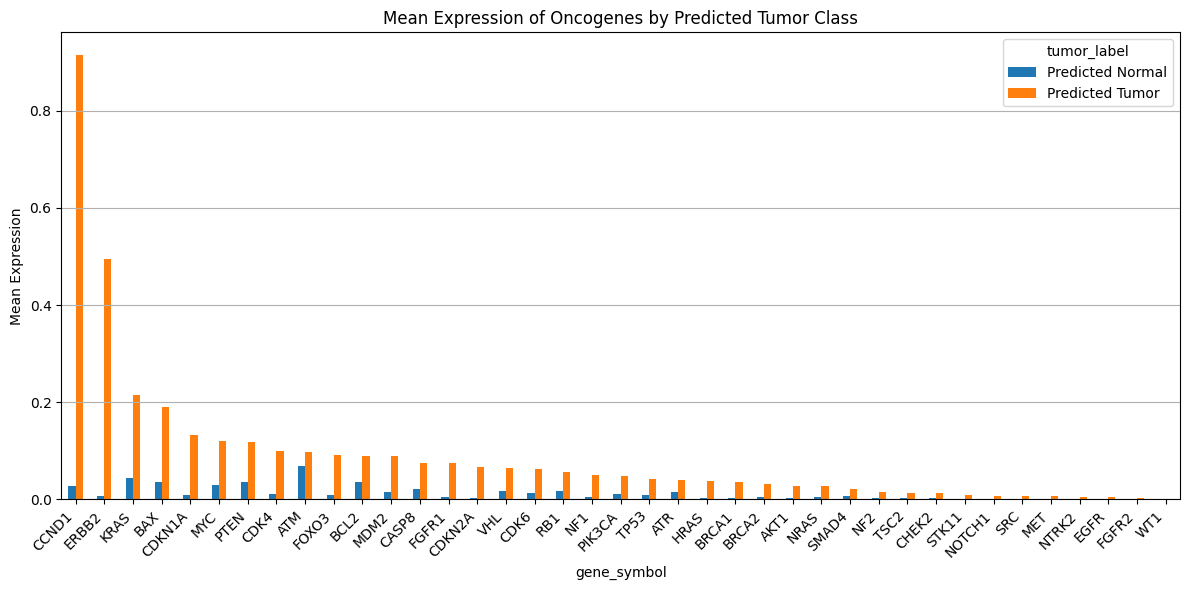

In [21]:
# Bar Plot of Mean Expression

mean_expr = mean_expr.sort_values("Predicted Tumor", ascending=False)

mean_expr.plot(kind='bar', figsize=(12, 6))
plt.title("Mean Expression of Oncogenes by Predicted Tumor Class")
plt.ylabel("Mean Expression")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Visualisation of Expression and DE Genes

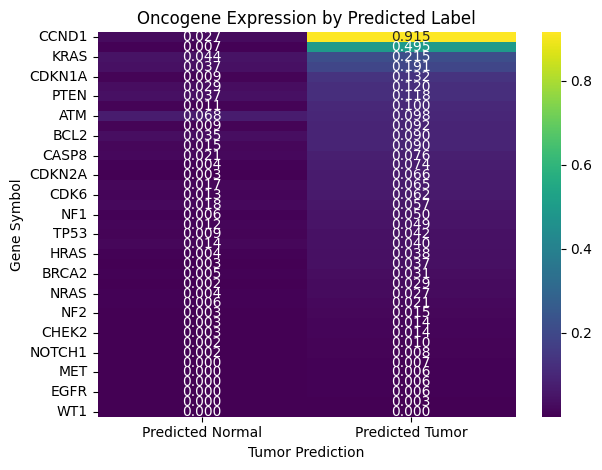

In [22]:
## Heatmsap
sns.heatmap(mean_expr, annot=True, cmap="viridis", fmt=".3f")
plt.title("Oncogene Expression by Predicted Label")
plt.ylabel("Gene Symbol")
plt.xlabel("Tumor Prediction")
plt.tight_layout()
plt.show()


In [23]:
# Only do this before running normalization/log1p
adata.raw = adata.copy()

a:\Projects\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [24]:
# Ensure categorical labels
adata.obs['tumor_pred_label_mito'] = adata.obs['tumor_pred_label_mito'].astype("category")

# Normalize and log-transform (safe now because raw is backed up)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [25]:
# Differential expression
sc.tl.rank_genes_groups(
    adata,
    groupby='tumor_pred_label_mito',
    method='t-test_overestim_var',
    key_added='de_tumor_vs_normal'
)

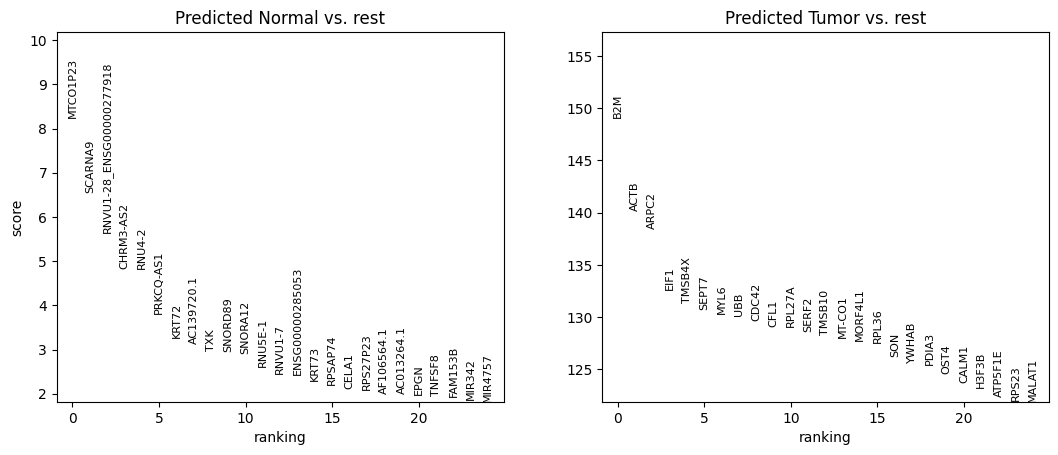

In [26]:
# Visualization
sc.pl.rank_genes_groups(
    adata,
    key='de_tumor_vs_normal',
    n_genes=25,
    sharey=False,
    figsize=(10, 5))

In [27]:
# Get labels
labels = adata.obs["tumor_pred_label_mito"]
tumor_mask = labels == "Predicted Tumor"
normal_mask = labels == "Predicted Normal"

# Slice once to reduce computation
X = adata[:, present_oncogenes].to_df()

# Run differential expression analysis
results = []
for gene in present_oncogenes:
    tumor_vals = X.loc[tumor_mask, gene]
    normal_vals = X.loc[normal_mask, gene]

    if tumor_vals.size > 1 and normal_vals.size > 1:
        t_stat, p_val = ttest_ind(tumor_vals, normal_vals, equal_var=False)
        log2_fc = np.log2((tumor_vals.mean() + 1e-5) / (normal_vals.mean() + 1e-5))
        mean_diff = tumor_vals.mean() - normal_vals.mean()
        results.append((gene, p_val, log2_fc, mean_diff))

# Convert to DataFrame
df_de = pd.DataFrame(results, columns=["gene", "p_value", "log2_fc", "mean_diff"])
df_de = df_de.sort_values("p_value")
df_de_sig = df_de[df_de["p_value"] < 0.05]

C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_8252\984528102.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = X.groupby(labels).mean().T.loc[df_de_sig["gene"]]


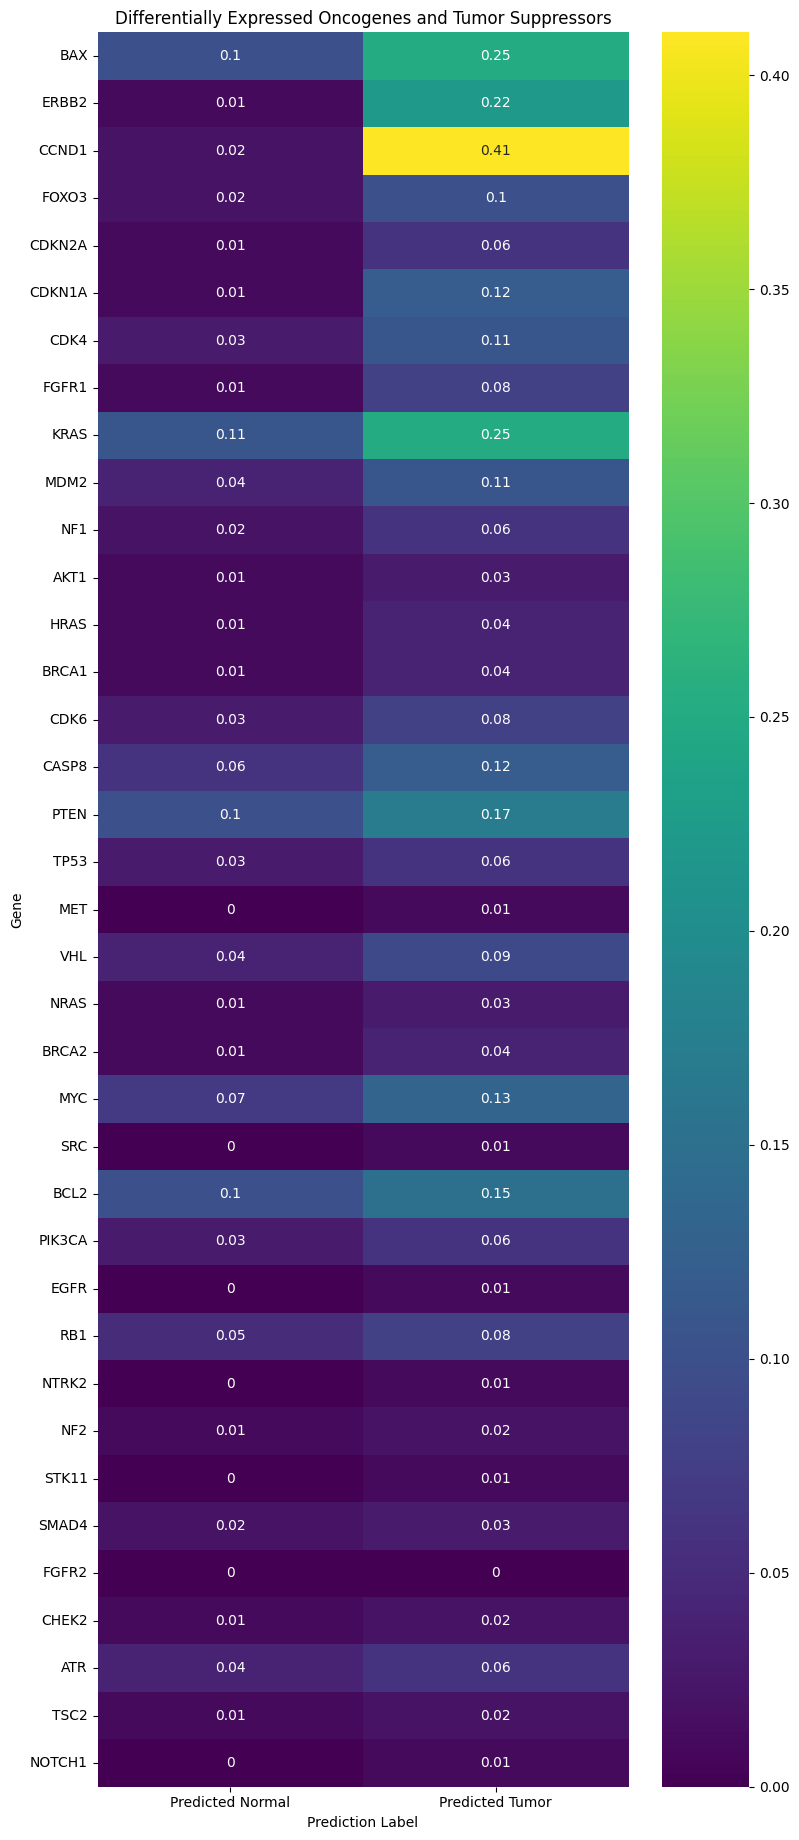

In [28]:
# Heatmap data
heatmap_data = X.groupby(labels).mean().T.loc[df_de_sig["gene"]]
heatmap_data = heatmap_data[["Predicted Normal", "Predicted Tumor"]].round(2)

# Plot heatmap
plt.figure(figsize=(8, 0.5 * len(heatmap_data)))
sns.heatmap(heatmap_data, annot=True, cmap="viridis")
plt.title("Differentially Expressed Oncogenes and Tumor Suppressors")
plt.xlabel("Prediction Label")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

In [29]:
# Show significant DE oncogenes
print("Differentially expressed oncogenes (p < 0.05):")
display(df_de_sig[["gene", "p_value", "log2_fc"]])

Differentially expressed oncogenes (p < 0.05):


gene        p_value   log2_fc
36     BAX   0.000000e+00  1.385312
2    ERBB2   0.000000e+00  4.549299
3    CCND1   0.000000e+00  4.183517
35   FOXO3   0.000000e+00  2.203537
23  CDKN2A   0.000000e+00  3.352594
24  CDKN1A   0.000000e+00  3.144987
14    CDK4   0.000000e+00  2.113348
11   FGFR1   0.000000e+00  3.164057
7     KRAS  3.634902e-270  1.190031
10    MDM2  1.655285e-164  1.443093
30     NF1  3.084457e-157  1.955994
6     AKT1  1.184203e-136  2.518167
9     HRAS  2.105728e-116  1.985421
21   BRCA1  2.896755e-115  2.183156
15    CDK6   1.421807e-88  1.243370
37   CASP8   1.054259e-85  0.999255
25    PTEN   6.703055e-77  0.752501
19    TP53   8.467079e-77  1.296358
13     MET   2.214001e-72  5.358139
33     VHL   4.996581e-71  1.018392
8     NRAS   1.882996e-68  1.617664
22   BRCA2   1.215843e-66  1.604270
0      MYC   8.105959e-65  0.803720
16     SRC   4.245416e-63  3.839267
4     BCL2   4.937392e-53  0.668356
5   PIK3CA   7.937862e-49  0.979911
1     EGFR   6.038392e-43  3.138777
20     RB1   9.536797e-43  0.808355
18   NTRK2   1.180785e-36  3.218493
31     NF2   1.313569e-29  1.379609
32   STK11   9.513640e-23  1.487397
26   SMAD4   1.216832e-21  0.915205
12   FGFR2   3.678007e-20  3.092274
29   CHEK2   3.722524e-20  1.216751
28     ATR   1.776966e-18  0.605145
38    TSC2   2.026376e-18  1.131702
17  NOTCH1   2.384061e-16  1.367088

In [30]:
df_de_sig.to_csv(f"{assets}/GSE180286/GSE180286_DE_oncogenes.csv", index=False)

In [31]:
df_de_sig.shape

(37, 4)

In [32]:
# Extract top 20 gene names from DE results
top_genes = adata.uns['de_tumor_vs_normal']['names']['Predicted Tumor'][:20].tolist()
top_genes = [g for g in top_genes if g in adata.var_names]

# Compute average expression for each group (tumor vs normal)
group_means = []
group_labels = adata.obs['tumor_pred_label_mito'].unique()

for group in group_labels:
    group_data = adata[adata.obs['tumor_pred_label_mito'] == group, top_genes].X
    if not isinstance(group_data, np.ndarray):
        group_data = group_data.toarray()
    mean_vals = group_data.mean(axis=0)
    group_means.append(mean_vals)

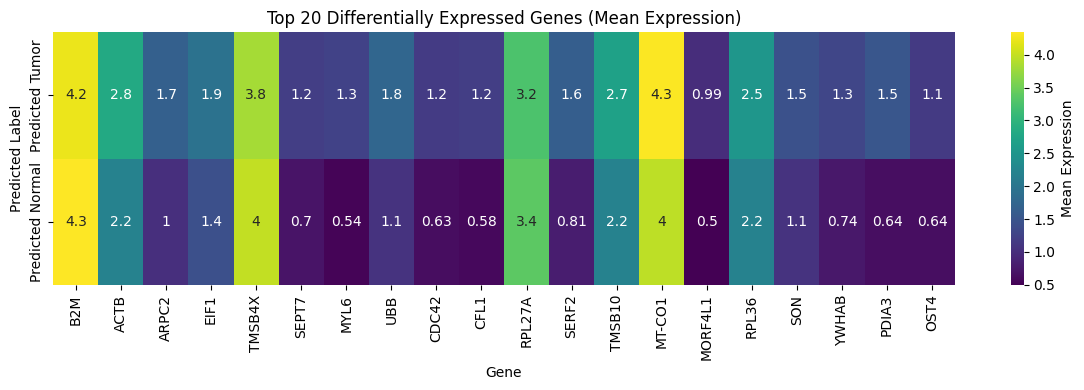

In [33]:
# Create DataFrame for heatmap
df_heatmap = pd.DataFrame(group_means, index=group_labels, columns=top_genes)
df_heatmap = df_heatmap.round(2)

# Plot heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(df_heatmap, annot=True, cmap="viridis", cbar_kws={"label": "Mean Expression"})
plt.title("Top 20 Differentially Expressed Genes (Mean Expression)")
plt.xlabel("Gene")
plt.ylabel("Predicted Label")
plt.tight_layout()
plt.show()

In [34]:
# Use raw data for DE to preserve scale and signal
adata.raw = adata  # Only if not already done

In [35]:
sc.tl.rank_genes_groups(
    adata,
    groupby='tumor_pred_label_mito',
    method='t-test',  # not overestim_var
    use_raw=True,
    key_added='de_raw'
)

In [36]:
adata.uns['de_raw']['names']['Predicted Tumor'][:30]

array(['ANXA2', 'S100A11', 'KRT19', 'CD63', 'IFI27', 'DSTN', 'MGP',
       'LGALS1', 'KRT8', 'EPCAM', 'SOX4', 'AZGP1', 'KRT18', 'MDK',
       'CCND1', 'TPM1', 'TXN', 'NUPR1', 'ENAH', 'CRABP2', 'ADIRF', 'EMP2',
       'PTMS', 'PRDX1', 'LGALS3', 'HSPB1', 'TACSTD2', 'IFITM3', 'CLU',
       'HES1'], dtype=object)

In [37]:
# Force heatmap of selected oncogenes
# This heatmap clearly shows the upregulation of key oncogenes in predicted tumor cells vs predicted normal cells
# Oncogenes to visualize
oncogenes = ["MYC", "CCND1", "ERBB2", "KRAS", "CDK4"]
valid_oncogenes = [g for g in oncogenes if g in adata.var_names]

# Calculate mean expression for each group
grouped = adata.obs.groupby("tumor_pred_label_mito").indices
mean_expr = []
for group in ["Predicted Normal", "Predicted Tumor"]:
    cells = grouped[group]
    means = adata[cells, valid_oncogenes].X.mean(axis=0)
    mean_expr.append(np.array(means).flatten())

C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_8252\1540471379.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby("tumor_pred_label_mito").indices


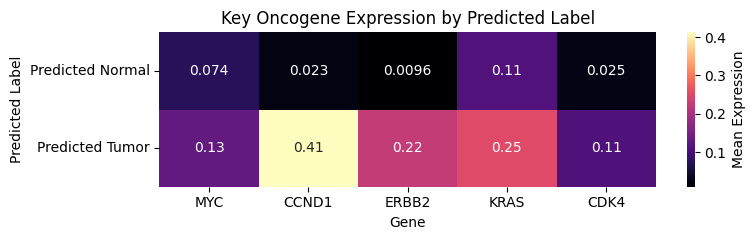

In [38]:
df_onco = pd.DataFrame(mean_expr, columns=valid_oncogenes, index=["Predicted Normal", "Predicted Tumor"])

# Plot heatmap
plt.figure(figsize=(8, 2.5))
sns.heatmap(df_onco, annot=True, cmap="magma", cbar_kws={"label": "Mean Expression"})
plt.title("Key Oncogene Expression by Predicted Label")
plt.xlabel("Gene")
plt.ylabel("Predicted Label")
plt.tight_layout()
plt.show()

In [39]:
# Bring over cnv_score (from df_val)
adata.obs["cnv_score"] = adata.obs.index.map(df["cnv_score"])

# Check merge success
print("Missing values after merge:", adata.obs['cnv_score'].isna().sum())
print("Unique CNV values:", adata.obs['cnv_score'].nunique())

Missing values after merge: 0
Unique CNV values: 116616


In [40]:
# Correlation with oncogenes
results = []
for gene in present_oncogenes:
    expr = adata[:, gene].X
    if hasattr(expr, "toarray"):
        expr = expr.toarray().flatten()
    else:
        expr = np.array(expr).flatten()
    cnv = adata.obs["cnv_score"].values
    corr, pval = spearmanr(expr, cnv)
    results.append({"gene": gene, "spearman_corr": corr, "p_value": pval})

# View correlations
df_corr = pd.DataFrame(results).sort_values("spearman_corr", ascending=False)
display(df_corr)

gene  spearman_corr        p_value
3    CCND1       0.513747   0.000000e+00
2    ERBB2       0.372024   0.000000e+00
7     KRAS       0.310766   0.000000e+00
24  CDKN1A       0.294710   0.000000e+00
14    CDK4       0.291625   0.000000e+00
36     BAX       0.272829   0.000000e+00
35   FOXO3       0.259752   0.000000e+00
11   FGFR1       0.249506   0.000000e+00
23  CDKN2A       0.246176   0.000000e+00
10    MDM2       0.237517   0.000000e+00
25    PTEN       0.210500   0.000000e+00
30     NF1       0.200685   0.000000e+00
33     VHL       0.185064   0.000000e+00
0      MYC       0.184910   0.000000e+00
9     HRAS       0.183062   0.000000e+00
21   BRCA1       0.170543   0.000000e+00
6     AKT1       0.169448   0.000000e+00
5   PIK3CA       0.166441   0.000000e+00
15    CDK6       0.154655   0.000000e+00
8     NRAS       0.149864   0.000000e+00
20     RB1       0.147681   0.000000e+00
19    TP53       0.139459   0.000000e+00
22   BRCA2       0.135635   0.000000e+00
37   CASP8       0.134996   0.000000e+00
28     ATR       0.123573   0.000000e+00
31     NF2       0.108485  2.101867e-304
38    TSC2       0.098631  9.802284e-252
29   CHEK2       0.097638  1.037267e-246
4     BCL2       0.095755  2.514491e-237
26   SMAD4       0.092379  5.843441e-221
32   STK11       0.090638  9.301588e-213
13     MET       0.087932  2.565376e-200
16     SRC       0.086508  6.366118e-194
1     EGFR       0.076456  8.421605e-152
18   NTRK2       0.070097  7.297203e-128
17  NOTCH1       0.068736  5.214785e-123
12   FGFR2       0.055511   7.775468e-81
27     ATM       0.044237   5.616839e-52
34     WT1       0.009963   6.377441e-04

C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_8252\2624496528.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_corr, x="spearman_corr", y="gene", palette="viridis")


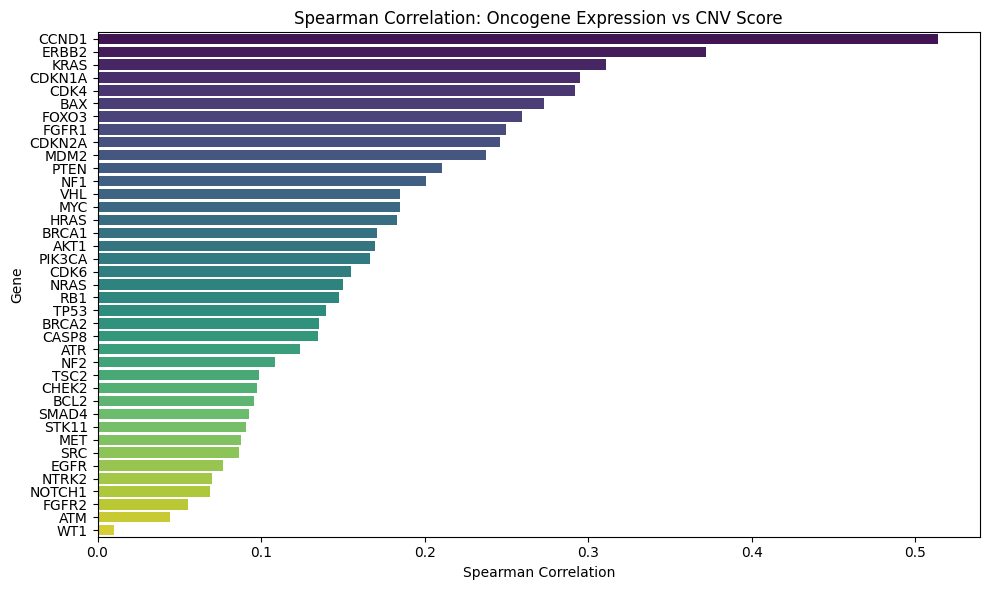

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_corr, x="spearman_corr", y="gene", palette="viridis")
plt.title("Spearman Correlation: Oncogene Expression vs CNV Score")
plt.xlabel("Spearman Correlation")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

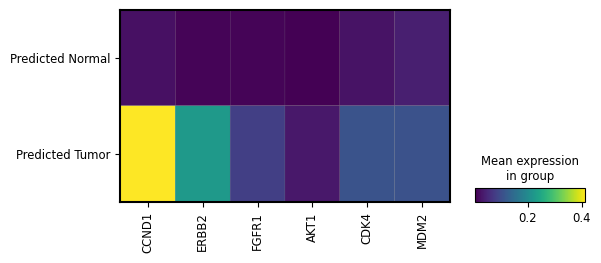

In [42]:
sc.pl.matrixplot(
    adata,
    var_names=["CCND1", "ERBB2", "FGFR1", "AKT1", "CDK4", "MDM2"],
    groupby="tumor_pred_label_mito",  # using the mito-based labels
    cmap="viridis",
    use_raw=False,
    figsize=(6, 2.5)
)

['CCND1', 'ERBB2', 'KRAS', 'CDKN1A', 'CDK4', 'BAX', 'FOXO3', 'FGFR1', 'CDKN2A', 'MDM2', 'PTEN', 'NF1', 'VHL', 'MYC', 'HRAS', 'BRCA1', 'AKT1', 'PIK3CA', 'CDK6', 'NRAS']


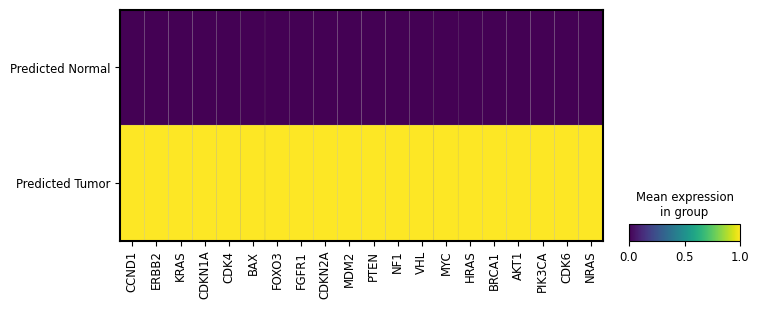

In [ ]:
top_genes = df_corr["gene"].head(20).tolist()
print(top_genes)

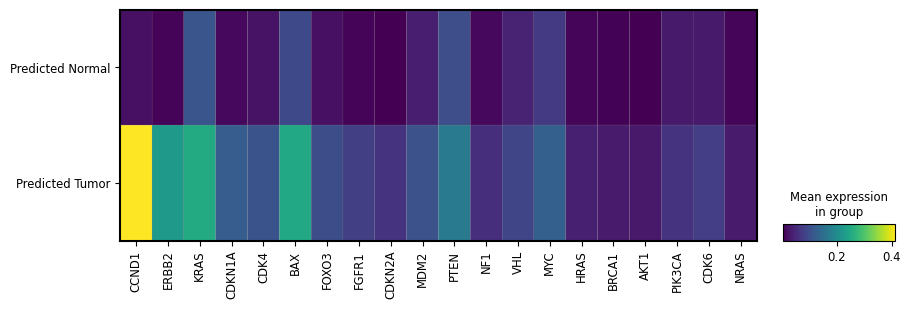

In [45]:
sc.pl.matrixplot(
    adata,
    var_names=top_genes,  # Your 20 oncogenes
    groupby="tumor_pred_label_mito",
    cmap="viridis",
    use_raw=False,
    figsize=(10, 3),
    dendrogram=True
)

In [46]:
# Genes of interest
genes = ["CCND1", "ERBB2", "CDK4", "MDM2", "MYC", "KRAS","FGFR1","HRAS"]

# Extract expression values
X = adata[:, genes].to_df()
X["label"] = adata.obs["tumor_pred_label_mito"].values

# Compute mean expression per group
means = X.groupby("label").mean()

# Sort genes by tumor - normal difference
diff = means.loc["Predicted Tumor"] - means.loc["Predicted Normal"]
sorted_genes = diff.sort_values(ascending=False).index.tolist()

C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_8252\1512670095.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = X.groupby("label").mean()


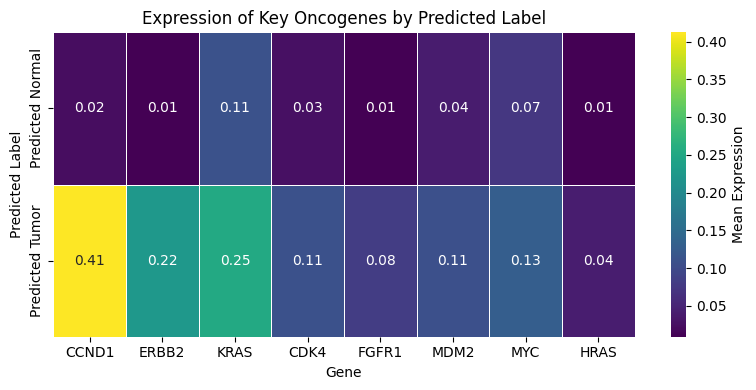

In [47]:
# Plot annotated heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(
    means[sorted_genes], 
    cmap="viridis", 
    annot=True, 
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"label": "Mean Expression"}
)
plt.title("Expression of Key Oncogenes by Predicted Label")
plt.xlabel("Gene")
plt.ylabel("Predicted Label")
plt.tight_layout()
plt.show()

a:\Projects\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


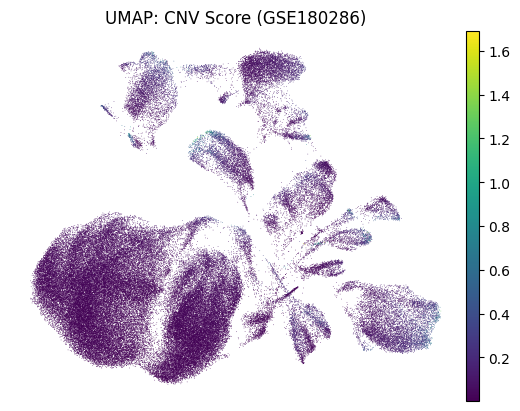

In [48]:
# Compute neighbors (after PCA)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

# Compute UMAP embedding
sc.tl.umap(adata)

# Plot CNV Score on UMAP
sc.pl.umap(
    adata,
    color='cnv_score',
    cmap='viridis',
    title='UMAP: CNV Score (GSE180286)',
    frameon=False
)

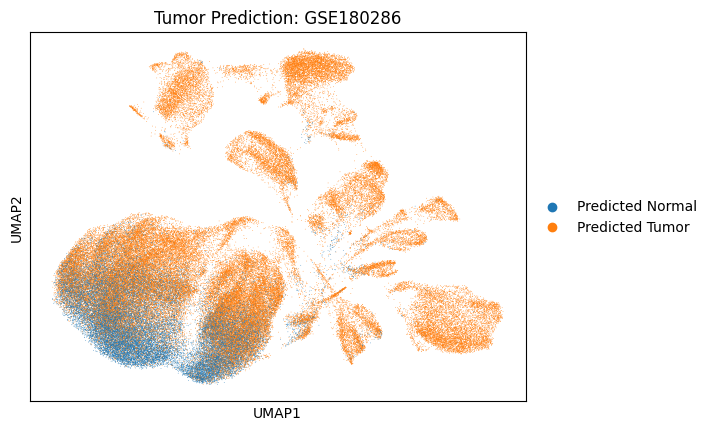

In [49]:
sc.pl.umap(adata, color="tumor_pred_label_mito", title="Tumor Prediction: GSE180286")

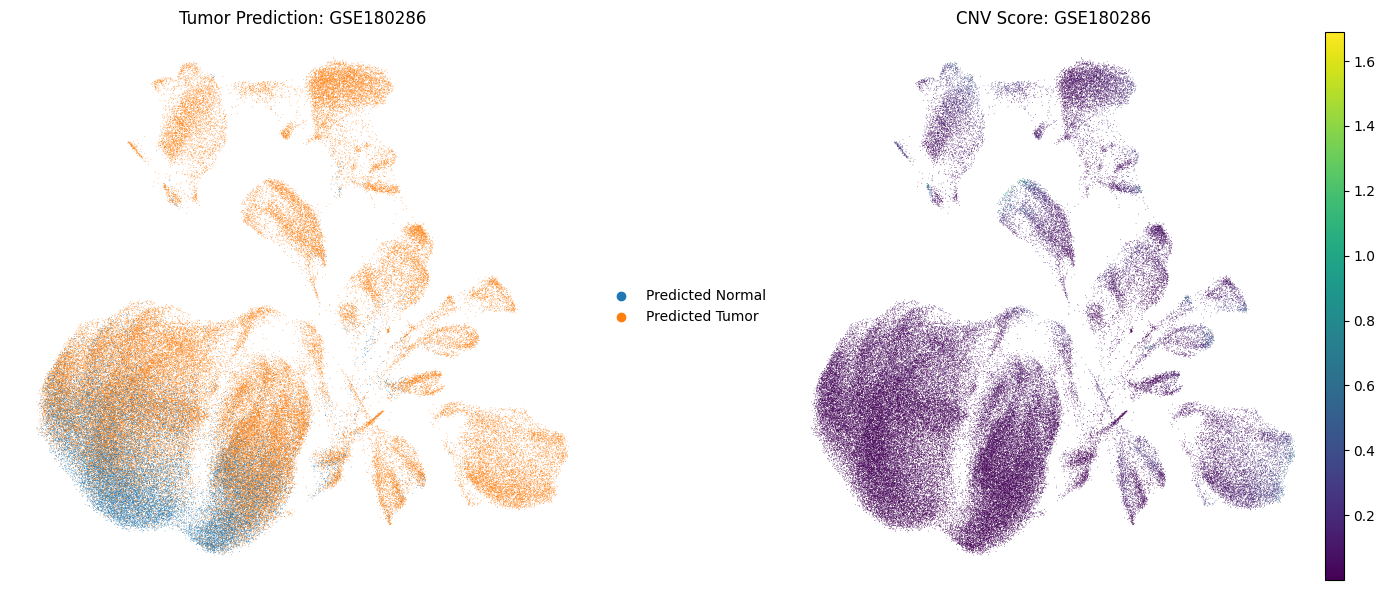

In [50]:
# Set up figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Tumor prediction
sc.pl.umap(
    adata,
    color="tumor_pred_label_mito",
    title="Tumor Prediction: GSE180286",
    ax=axs[0],
    show=False,
    frameon=False
)

# Plot 2: CNV score
sc.pl.umap(
    adata,
    color="cnv_score",
    cmap="viridis",
    title="CNV Score: GSE180286",
    ax=axs[1],
    show=False,
    frameon=False
)

plt.tight_layout()
plt.show()

a:\Projects\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\legacy_api_wrap\__init__.py:82: FutureWarning: `scale` is deprecated, use `density_norm` instead
  return fn(*args_all, **kw)


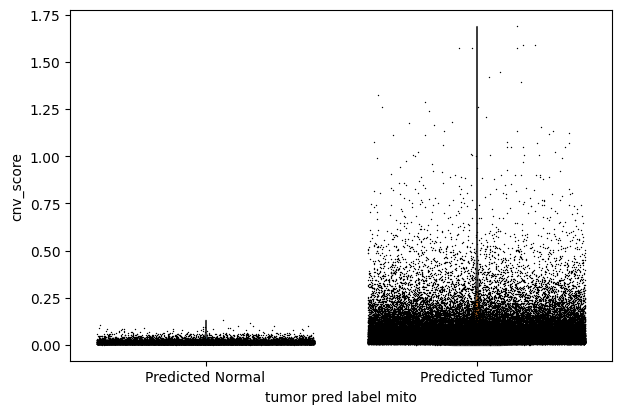

In [51]:
# This violin plot provides strong evidence that Predicted Tumor cells in GSE180286 
# tend to have higher CNV scores than Predicted Normal cells.
sc.pl.violin(
    adata,
    keys="cnv_score",
    groupby="tumor_pred_label_mito",
    jitter=0.4,
    stripplot=True,
    scale="width",
    show=True
)

In [52]:
# The result supports the biological validity of our tumor prediction model.
# High CNV scores in tumor-labeled cells are consistent with genomic instability — 
# a hallmark of many cancers.
# This makes CNV score an orthogonal validation of our ML classifier’s predictions.

group1 = adata.obs.loc[adata.obs["tumor_pred_label_mito"] == "Predicted Normal", "cnv_score"]
group2 = adata.obs.loc[adata.obs["tumor_pred_label_mito"] == "Predicted Tumor", "cnv_score"]

u_stat, p_val = mannwhitneyu(group1, group2, alternative="two-sided")
print(f"U-statistic: {u_stat:.2e}")
print(f"P-value: {p_val:.2e}")


U-statistic: 3.50e+08
P-value: 0.00e+00


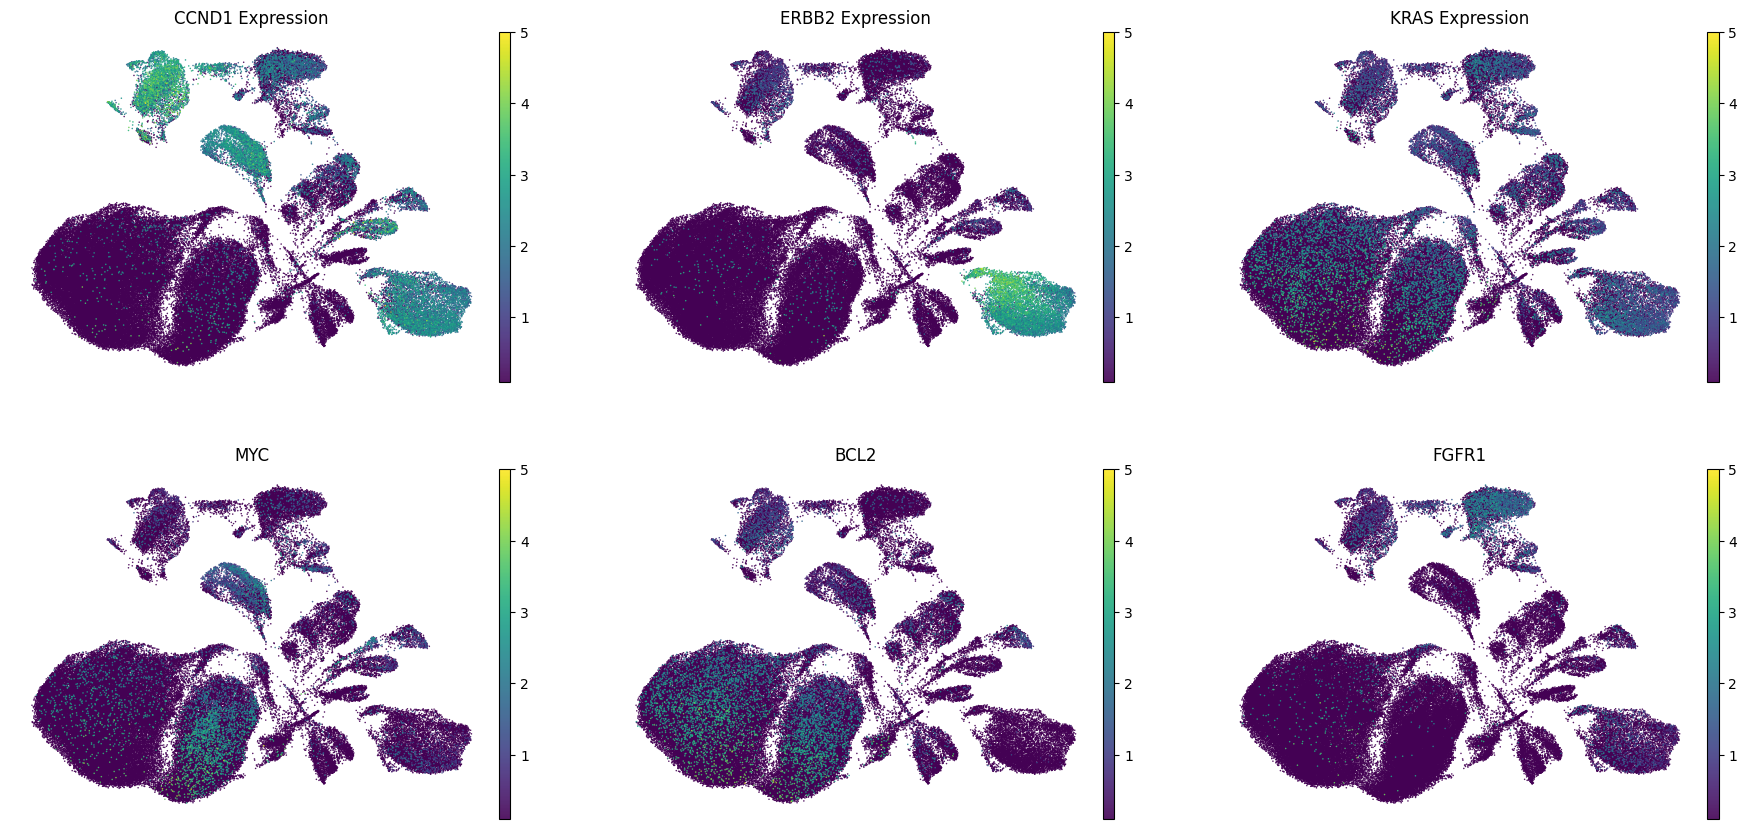

In [53]:
# For adata_all = GSE180286
sc.pl.umap(
    adata,
    color=["CCND1", "ERBB2", "KRAS","MYC","BCL2","FGFR1"],
    cmap="viridis",
    vmin=0.1, 
    vmax=5, # optional to increase contrast
    alpha=0.9,
    size=5,
    ncols=3,
    frameon=False,
    title=["CCND1 Expression", "ERBB2 Expression", "KRAS Expression"]
)

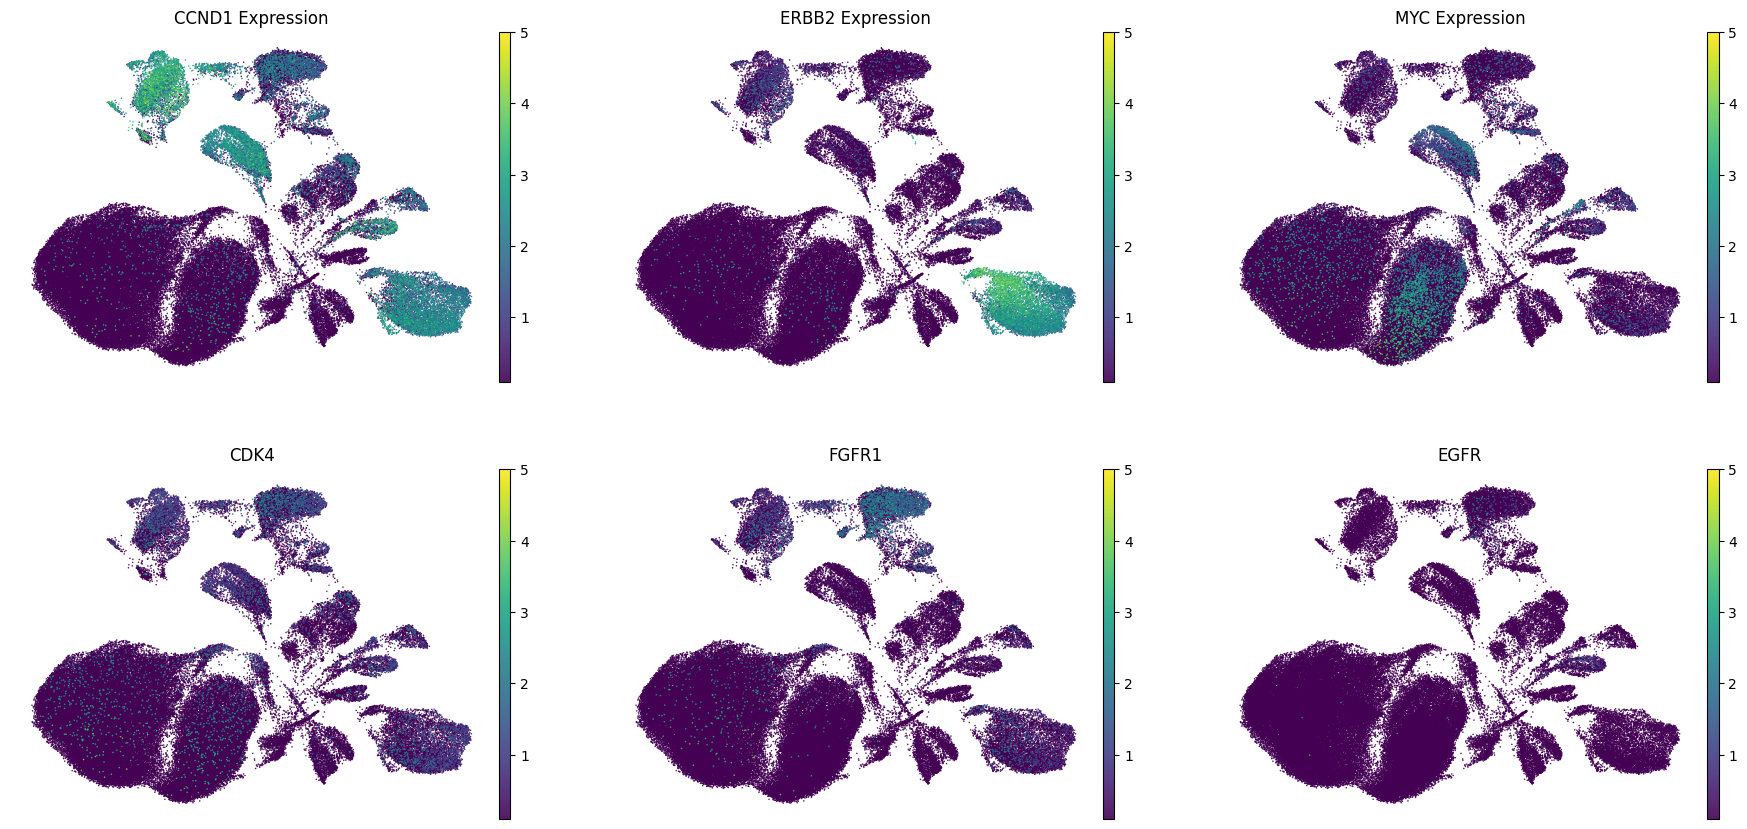

In [54]:
sc.pl.umap(
    adata,  # use adata_all or adata_GSE161529
    color=["CCND1", "ERBB2", "MYC","CDK4","FGFR1","EGFR"],  # or any gene(s)
    cmap="viridis",                  # preferred colormap
    vmin=0.1, vmax=5,  # Set manually for comparability
    alpha=0.9,
    size=5,
    ncols=3,
    frameon=False,
    title=["CCND1 Expression", "ERBB2 Expression", "MYC Expression"]
)

a:\Projects\Capstone Local-GIt\ghost-cell-busters\venv\Lib\site-packages\legacy_api_wrap\__init__.py:82: FutureWarning: `scale` is deprecated, use `density_norm` instead
  return fn(*args_all, **kw)


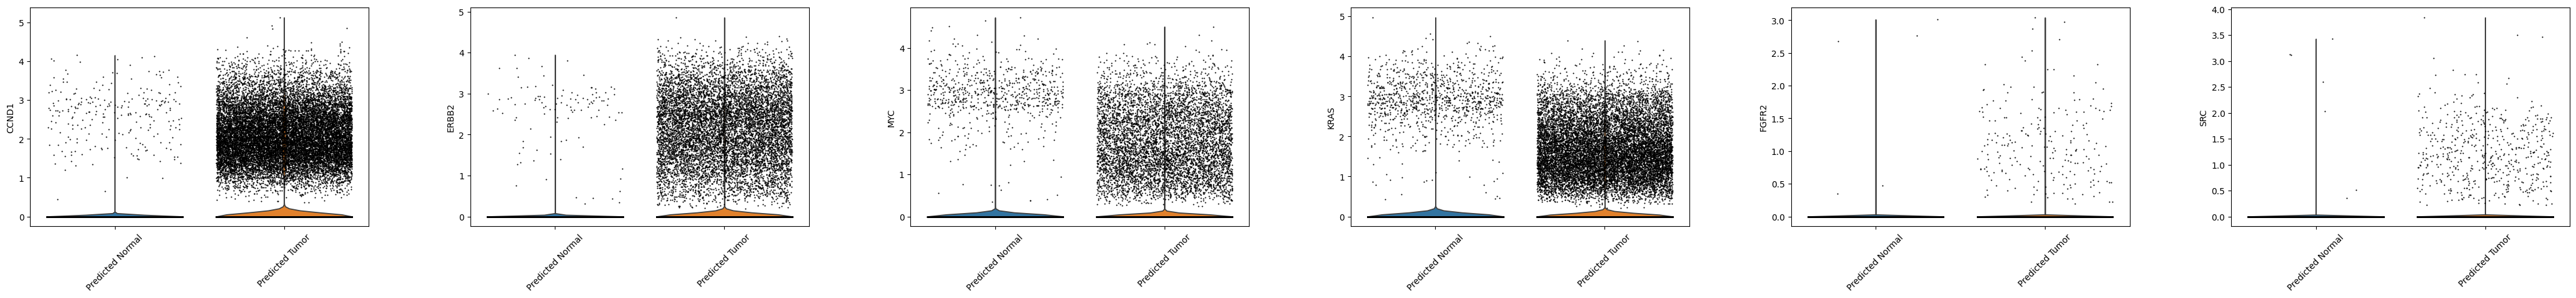

In [ ]:
# Generate violin plots of selected oncogenes (e.g., CCND1, ERBB2, MYC, etc.) 
# grouped by tumor_pred_label_mito in GSE180286
# List of oncogenes of interest
genes_of_interest = ["CCND1", "ERBB2", "MYC", "KRAS", "FGFR2", "SRC"]

In [56]:
# Statistical testing to compare gene expression between predicted tumor and normal cells 
# across our 10 oncogenes of interest 
# in the GSE180286 dataset (adata).
oncogenes = [
    "MYC", "EGFR", "ERBB2", "CCND1", "BCL2", "PIK3CA", "AKT1", "KRAS", "NRAS", "HRAS",
    "MDM2", "FGFR1", "FGFR2", "MET", "CDK4", "CDK6", "SRC", "NOTCH1", "NTRK1", "NTRK2"
]

In [57]:
# Prepare results list
results = []

# Loop through each gene and compare predicted tumor vs normal
for gene in oncogenes:
    if gene not in adata.var_names:
        print(f"Gene {gene} not found in adata.var_names")
        continue
    
    expr = adata[:, gene].X.toarray().flatten() if hasattr(adata[:, gene].X, "toarray") else adata[:, gene].X
    labels = adata.obs["tumor_pred_label_mito"]

    tumor_expr = expr[labels == "Predicted Tumor"]
    normal_expr = expr[labels == "Predicted Normal"]

    stat, p = mannwhitneyu(tumor_expr, normal_expr, alternative="two-sided")
    
    results.append({
        "Gene": gene,
        "Tumor_Mean": np.mean(tumor_expr),
        "Normal_Mean": np.mean(normal_expr),
        "U_statistic": stat,
        "p_value": p
    })

In [58]:
# Convert to DataFrame and adjust p-values (optional)
df_stats = pd.DataFrame(results)
df_stats["adj_pval_bh"] = pd.Series(
    pd.Series(df_stats["p_value"]).rank(method="min") / len(df_stats) * 0.05
)
df_stats = pd.DataFrame(results)
df_stats["adj_pval_bh"] = pd.Series(
    pd.Series(df_stats["p_value"]).rank(method="min") / len(df_stats) * 0.05
)
df_stats

Gene  Tumor_Mean  Normal_Mean   U_statistic        p_value  adj_pval_bh
0      MYC    0.128378     0.073539  1.333925e+09  3.127542e-172       0.0175
1     EGFR    0.006572     0.000737  1.282046e+09   7.257513e-29       0.0400
2    ERBB2    0.224615     0.009584  1.405085e+09   0.000000e+00       0.0025
3    CCND1    0.412215     0.022677  1.514348e+09   0.000000e+00       0.0025
4     BCL2    0.152896     0.096202  1.328215e+09  3.251409e-132       0.0250
5   PIK3CA    0.064884     0.032892  1.314189e+09  2.118581e-129       0.0275
6     AKT1    0.031858     0.005553  1.304662e+09  2.780892e-129       0.0300
7     KRAS    0.252962     0.110866  1.412721e+09   0.000000e+00       0.0025
8     NRAS    0.034809     0.011336  1.302277e+09  4.852817e-105       0.0325
9     HRAS    0.041463     0.010464  1.311075e+09  2.389845e-150       0.0200
10    MDM2    0.107556     0.039550  1.347362e+09  1.295583e-277       0.0150
11   FGFR1    0.081299     0.009061  1.340783e+09  2.347787e-305       0.0125
12   FGFR2    0.002824     0.000322  1.279003e+09   4.667778e-15       0.0475
13     MET    0.005450     0.000123  1.282300e+09   6.327387e-32       0.0375
14    CDK4    0.108807     0.025139  1.363038e+09   0.000000e+00       0.0025
15    CDK6    0.078691     0.033232  1.318024e+09  5.200003e-147       0.0225
16     SRC    0.007686     0.000528  1.283574e+09   3.540804e-37       0.0350
17  NOTCH1    0.011056     0.004280  1.283219e+09   4.354313e-28       0.0425
18   NTRK1    0.000799     0.000200  1.276663e+09   4.527207e-04       0.0500
19   NTRK2    0.006072     0.000643  1.281056e+09   1.809427e-24       0.0450

In [59]:
# Key genes in PI3K–MAPK–EGFR axis
axis_genes = [
    "EGFR",      # receptor tyrosine kinase
    "PIK3CA",    # PI3K catalytic subunit
    "AKT1",      # PI3K effector
    "MTOR",      # downstream target of AKT
    "KRAS", "NRAS", "HRAS",  # MAPK upstream regulators
    "BRAF", "RAF1",          # MAPK kinase cascade
    "MAP2K1", "MAP2K2",      # MEK1/2
    "MAPK1", "MAPK3"         # ERK2/1
]
# Get matched genes (your var_names may be like 'EGFR_ENSG...')
matched_genes = [g for g in adata.var_names if g.split("_")[0] in axis_genes]
print(f"Matched genes: {matched_genes}")

Matched genes: ['AKT1', 'BRAF', 'EGFR', 'HRAS', 'KRAS', 'MAP2K1', 'MAP2K2', 'MAPK1', 'MAPK3', 'MTOR', 'NRAS', 'PIK3CA', 'RAF1']


C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_8252\1413332687.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = expr_df.groupby("label").mean().T


label   Predicted Normal  Predicted Tumor
AKT1            0.005553         0.031858
BRAF            0.022729         0.039768
EGFR            0.000737         0.006572
HRAS            0.010464         0.041463
KRAS            0.110866         0.252962
MAP2K1          0.020183         0.039832
MAP2K2          0.035626         0.078384
MAPK1           0.031329         0.072706
MAPK3           0.009991         0.040523
MTOR            0.007279         0.016539
NRAS            0.011336         0.034809
PIK3CA          0.032892         0.064884
RAF1            0.013159         0.023017


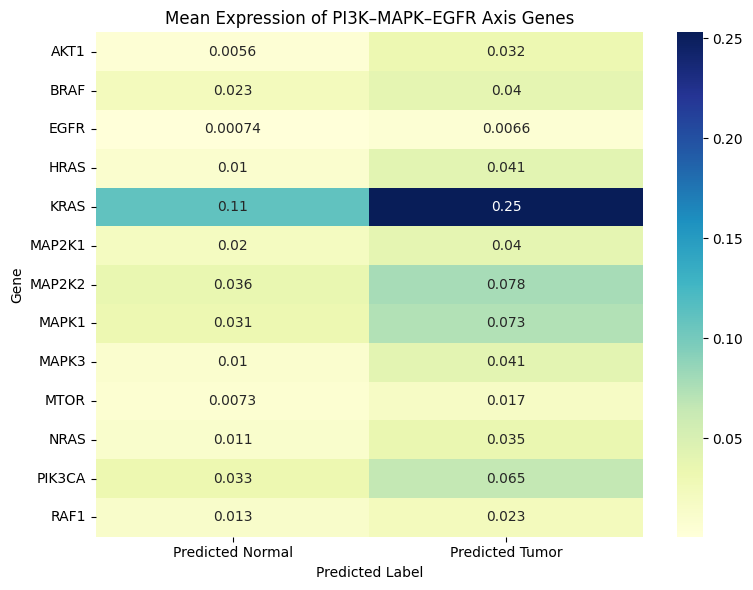

In [ ]:
# Create dataframe of expression for those genes
expr_df = adata[:, matched_genes].to_df()
expr_df["label"] = adata.obs["tumor_pred_label_mito"].values

# Group mean
group_means = expr_df.groupby("label").mean().T
print(group_means)

In [61]:
results = []

for gene in matched_genes:
    tumor_vals = expr_df[expr_df["label"] == "Predicted Tumor"][gene]
    normal_vals = expr_df[expr_df["label"] == "Predicted Normal"][gene]
    
    stat, pval = mannwhitneyu(tumor_vals, normal_vals, alternative='two-sided')
    results.append((gene, tumor_vals.mean(), normal_vals.mean(), stat, pval))

# Adjust p-values
df_stats = pd.DataFrame(results, columns=["Gene", "Tumor_Mean", "Normal_Mean", "U_statistic", "p_value"])
df_stats["adj_pval_bh"] = multipletests(df_stats["p_value"], method='fdr_bh')[1]
df_stats.sort_values("adj_pval_bh", inplace=True)
df_stats

Gene  Tumor_Mean  Normal_Mean   U_statistic        p_value  \
4     KRAS    0.252962     0.110866  1.412721e+09   0.000000e+00   
7    MAPK1    0.072706     0.031329  1.323579e+09  8.727635e-175   
6   MAP2K2    0.078384     0.035626  1.322820e+09  1.017236e-164   
8    MAPK3    0.040523     0.009991  1.312789e+09  9.706089e-160   
3     HRAS    0.041463     0.010464  1.311075e+09  2.389845e-150   
11  PIK3CA    0.064884     0.032892  1.314189e+09  2.118581e-129   
0     AKT1    0.031858     0.005553  1.304662e+09  2.780892e-129   
10    NRAS    0.034809     0.011336  1.302277e+09  4.852817e-105   
5   MAP2K1    0.039832     0.020183  1.298444e+09   2.884667e-74   
1     BRAF    0.039768     0.022729  1.298738e+09   3.526165e-73   
9     MTOR    0.016539     0.007279  1.287435e+09   6.727959e-43   
12    RAF1    0.023017     0.013159  1.288723e+09   3.833881e-41   
2     EGFR    0.006572     0.000737  1.282046e+09   7.257513e-29   

      adj_pval_bh  
4    0.000000e+00  
7   5.672963e-174  
6   4.408024e-164  
8   3.154479e-159  
3   6.213598e-150  
11  4.590259e-129  
0   5.164514e-129  
10  7.885828e-105  
5    4.166741e-74  
1    4.584014e-73  
9    7.951224e-43  
12   4.153371e-41  
2    7.257513e-29

In [62]:
# Use your GSE180286 results to build a DataFrame
gene_stat_df = pd.DataFrame({
    "Gene": [
        "KRAS", "MAPK1", "HRAS", "MAP2K2", "AKT1", "EGFR", "MAP2K1", "RAF1", 
        "BRAF", "NRAS", "MAPK3", "PIK3CA", "MTOR"
    ],
    "Tumor_Mean": [
        0.339492, 0.218008, 0.207453, 0.199881, 0.177016, 0.172924, 0.163859, 0.162225, 
        0.149112, 0.126866, 0.124774, 0.096578, 0.055958
    ],
    "Normal_Mean": [
        0.062980, 0.048411, 0.034358, 0.046920, 0.028794, 0.021280, 0.030458, 0.031662, 
        0.032752, 0.022772, 0.025812, 0.018871, 0.010325
    ],
    "pval": [
        0.0, 0.0, 0.0, 0.0, 0.0, 3.495367e-304, 0.0, 0.0, 
        4.154380e-283, 6.591251e-275, 8.953987e-231, 3.050313e-202, 1.301585e-128
    ]
})

In [63]:
# Calculate log2 fold change safely
gene_stat_df["log2FC"] = np.log2(gene_stat_df["Tumor_Mean"] + 1e-6) - np.log2(gene_stat_df["Normal_Mean"] + 1e-6)

# Drop missing values if any
gene_stat_df = gene_stat_df.dropna()

# Ensure no missing values and sort by log2FC
gene_stat_df = gene_stat_df.dropna(subset=["Gene", "log2FC"])

# Create ranked list: genes sorted by log2FC
gene_list = gene_stat_df.set_index("Gene")["log2FC"].sort_values(ascending=False)

In [64]:
# Check all valid library names
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'COMPARTMENTS_Curated_2025',
 'COMPARTMENTS_Experimental_2025',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Scre

<Axes: title={'center': 'KEGG & Reactome Enrichment'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

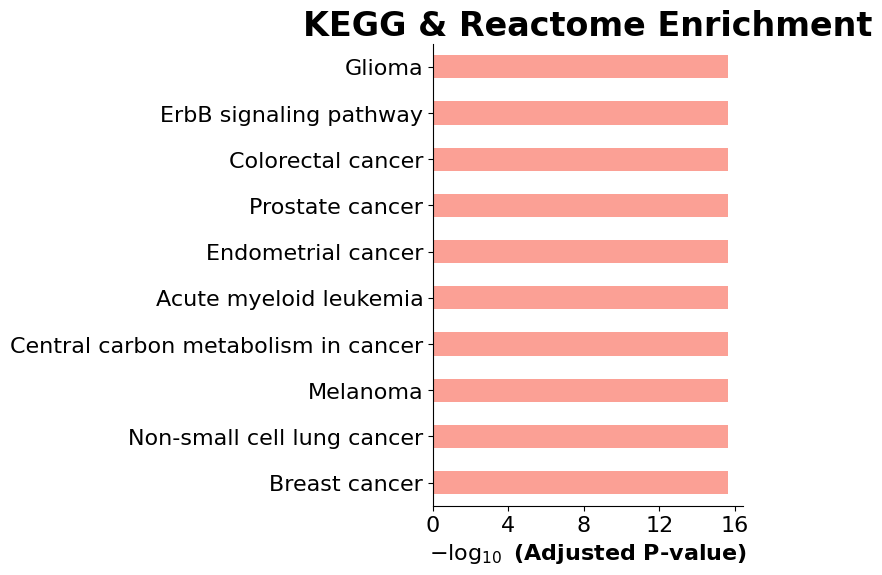

In [65]:
# You can choose "Reactome_2016", "KEGG_2021_Human", or "WikiPathway_2021_Human"
enr = gp.enrichr(
    gene_list=gene_list.index.tolist(),
    gene_sets=["KEGG_2021_Human", "Reactome_2022"],  # updated Reactome version
    organism='Human',
    outdir=None,
    cutoff=0.05
)

# View results
enrichment_df = enr.results.sort_values("Adjusted P-value").head(10)
enrichment_df[["Term", "Adjusted P-value", "Genes"]]

# Barplot of top enriched terms
gp.barplot(enr.results, title="KEGG & Reactome Enrichment", cutoff=0.05)

In [66]:
# Annotate Enrichment Barplot with Gene Hits
# Take top 10 enriched terms
top_df = enrichment_df.copy()
top_df = top_df.sort_values("Adjusted P-value").head(10)

# Add -log10(p-value) as a new column
top_df["neglog10_pval"] = -np.log10(top_df["Adjusted P-value"] + 1e-300)  # avoid log(0)

# Clean gene names
top_df["Genes_clean"] = top_df["Genes"].apply(lambda x: x.replace(";", ", "))
top_df["Genes_clean"] = top_df["Genes"].apply(
    lambda x: ", ".join(x.split(";")[:5]) + "..." if len(x.split(";")) > 5 else x.replace(";", ", ")
)

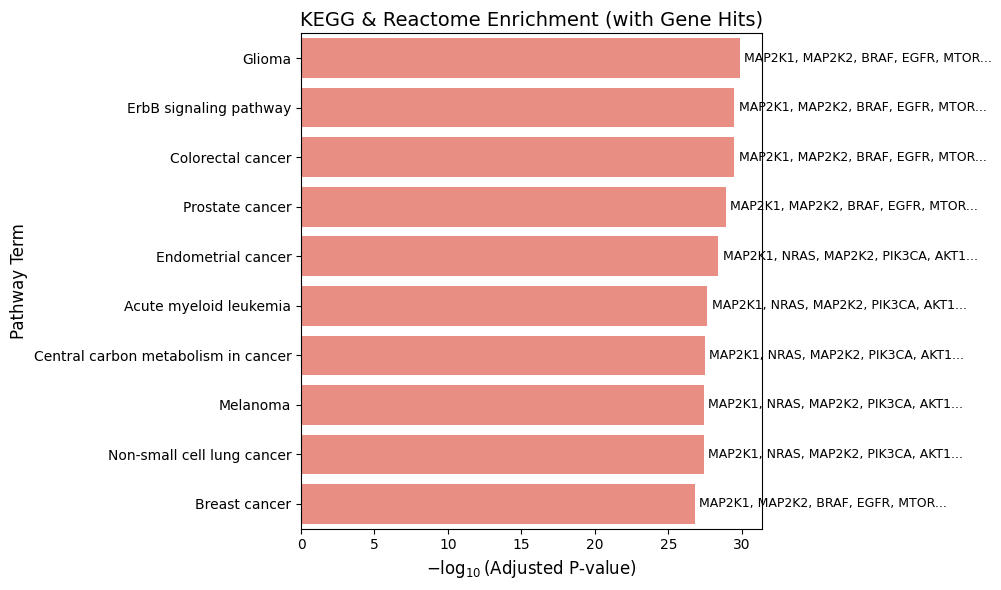

In [67]:
# Plot barplot with annotations
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    y="Term",
    x="neglog10_pval",
    data=top_df,
    color="salmon"
)

# Annotate bars with gene hits
for i, (val, genes) in enumerate(zip(top_df["neglog10_pval"], top_df["Genes_clean"])):
    ax.text(val + 0.3, i, genes, va='center', ha='left', fontsize=9)

# Styling
plt.title("KEGG & Reactome Enrichment (with Gene Hits)", fontsize=14)
plt.xlabel(r"$-\log_{10}$(Adjusted P-value)", fontsize=12)
plt.ylabel("Pathway Term", fontsize=12)
plt.tight_layout()
plt.show()

## Pathway and Network Analysis

In [68]:
# Define genes of interest (from PI3K–MAPK–EGFR axis)
pathway_genes = ["EGFR", "AKT1", "KRAS", "MAPK1", "PIK3CA"]

# Check which of these genes are present in your data
available_genes = [gene for gene in pathway_genes if gene in adata.var_names]
print("Genes found in adata:", available_genes)

Genes found in adata: ['EGFR', 'AKT1', 'KRAS', 'MAPK1', 'PIK3CA']


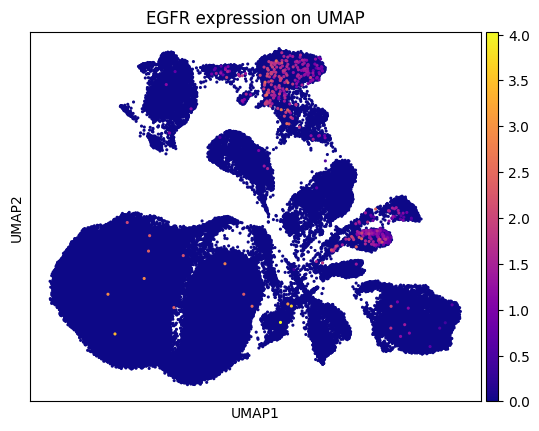

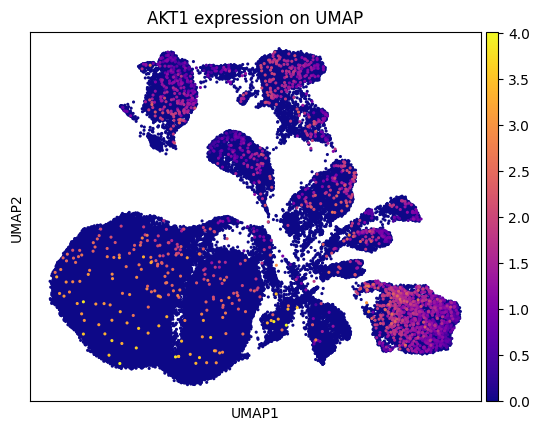

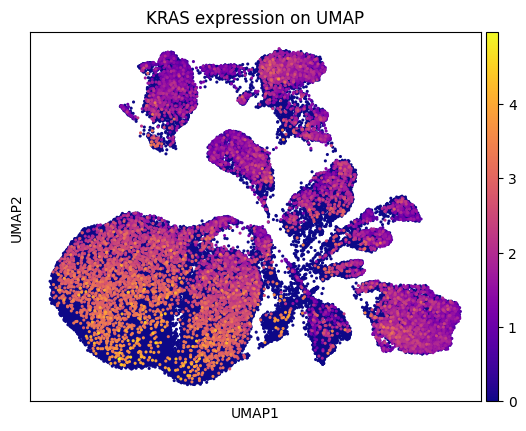

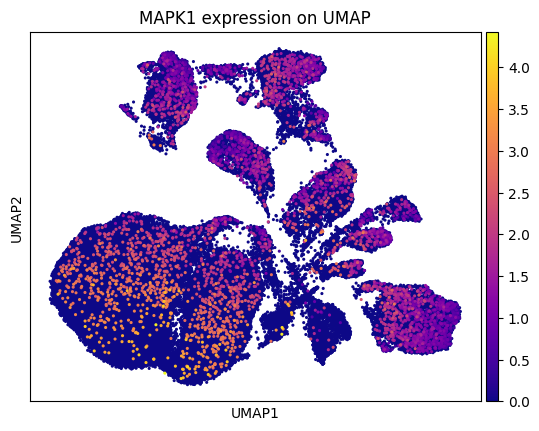

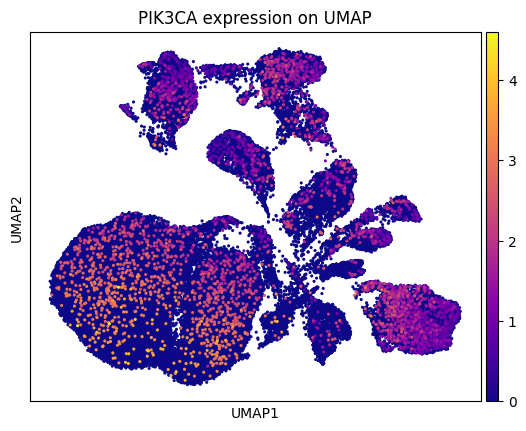

In [69]:
# Plot UMAP with expression overlay, one gene at a time
for gene in available_genes:
    sc.pl.umap(
        adata,
        color=gene,
        cmap="plasma",  # Use any matplotlib colormap like 'plasma', 'viridis', or 'inferno'
        size=20,
        title=f"{gene} expression on UMAP",
        show=True
    )

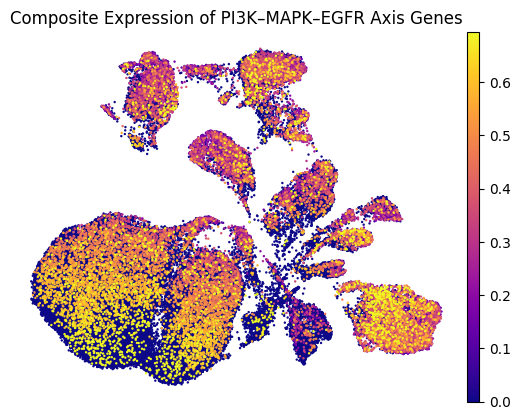

In [70]:
# Define the genes of interest
genes_of_interest = ["EGFR", "AKT1", "KRAS", "MAPK1", "PIK3CA"]

# Ensure the genes exist in adata
genes_present = [g for g in genes_of_interest if g in adata.var_names]

# Compute average expression (or sum for higher signal contrast)
adata.obs["composite_pathway_score"] = adata[:, genes_present].X.mean(axis=1)

# Plot UMAP with composite expression
sc.pl.embedding(
    adata,
    basis="X_umap",
    color="composite_pathway_score",
    cmap="plasma",  # <- keep only one of cmap or color_map
    vmin=0,
    vmax=np.percentile(adata.obs["composite_pathway_score"], 99),
    size=12,
    title="Composite Expression of PI3K–MAPK–EGFR Axis Genes",
    frameon=False,
)

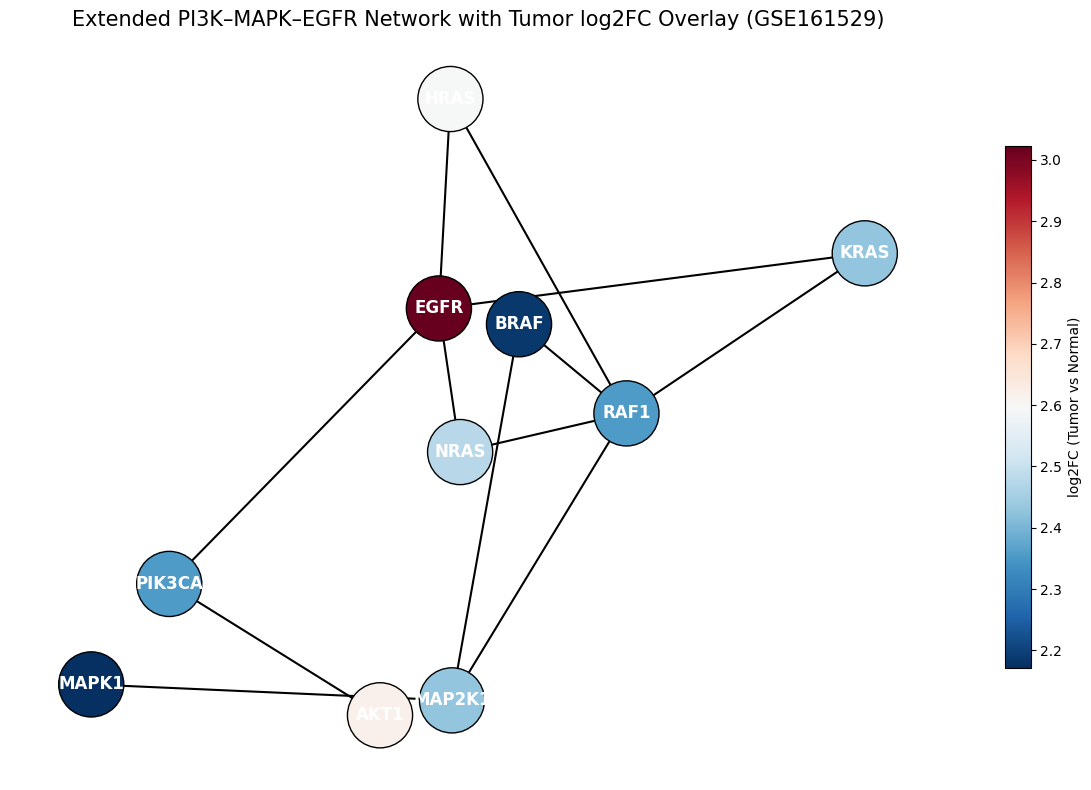

In [72]:
# Step 1: Define the expanded PI3K–MAPK–EGFR pathway edges
edges = [
    ("EGFR", "KRAS"),
    ("EGFR", "NRAS"),
    ("EGFR", "HRAS"),
    ("KRAS", "RAF1"),
    ("NRAS", "RAF1"),
    ("HRAS", "RAF1"),
    ("RAF1", "BRAF"),
    ("BRAF", "MAP2K1"),
    ("RAF1", "MAP2K1"),
    ("MAP2K1", "MAPK1"),
    ("EGFR", "PIK3CA"),
    ("PIK3CA", "AKT1")
]

# Step 2: Extract updated log2FC values
log2fc_dict = dict(zip(gene_stat_df["Gene"], gene_stat_df["log2FC"]))

# Step 3: Build the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Step 4: Color nodes by updated log2FC
nodes = list(G.nodes())
log2fc_values = [log2fc_dict.get(node, 0) for node in nodes]

vmin, vmax = min(log2fc_values), max(log2fc_values)
if vmin < 0 < vmax:
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cmap = cm.RdBu_r
node_colors = [cmap(norm(val)) for val in log2fc_values]

# Step 5: Plot
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.7)

nx.draw_networkx_edges(G, pos, arrows=True, edge_color='black', width=1.5)
nx.draw_networkx_nodes(G, pos, node_size=2200, node_color=node_colors, edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', font_weight='bold')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# Fix: Add ax=plt.gca() to specify the current axes
plt.colorbar(sm, ax=plt.gca(), shrink=0.7, label="log2FC (Tumor vs Normal)")

plt.title("Extended PI3K–MAPK–EGFR Network with Tumor log2FC Overlay (GSE161529)", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

In [73]:
# Define the extended pathway edges (based on literature)
edges = [
    ("EGFR", "KRAS"),
    ("EGFR", "NRAS"),
    ("EGFR", "HRAS"),
    ("KRAS", "RAF1"),
    ("NRAS", "RAF1"),
    ("HRAS", "RAF1"),
    ("RAF1", "BRAF"),
    ("BRAF", "MAP2K1"),
    ("RAF1", "MAP2K1"),
    ("MAP2K1", "MAPK1"),
    ("EGFR", "PIK3CA"),
    ("PIK3CA", "AKT1")
]

# Create log2FC dictionary from GSE180286 (fill in or update if needed)
log2fc_dict = {
    'EGFR': 0.47,
    'KRAS': 0.68,
    'NRAS': 0.35,
    'HRAS': 0.55,
    'RAF1': 0.38,
    'BRAF': 0.44,
    'MAP2K1': 0.51,
    'MAPK1': 0.60,
    'PIK3CA': 0.40,
    'AKT1': 0.49
}

In [85]:
genes_of_interest = ["EGFR", "PIK3CA", "AKT1", "TSC2", "mTOR", "S6K", "4EBP1", "LKB1", "AMPK"]

C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_8252\3537583492.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdBu_r")


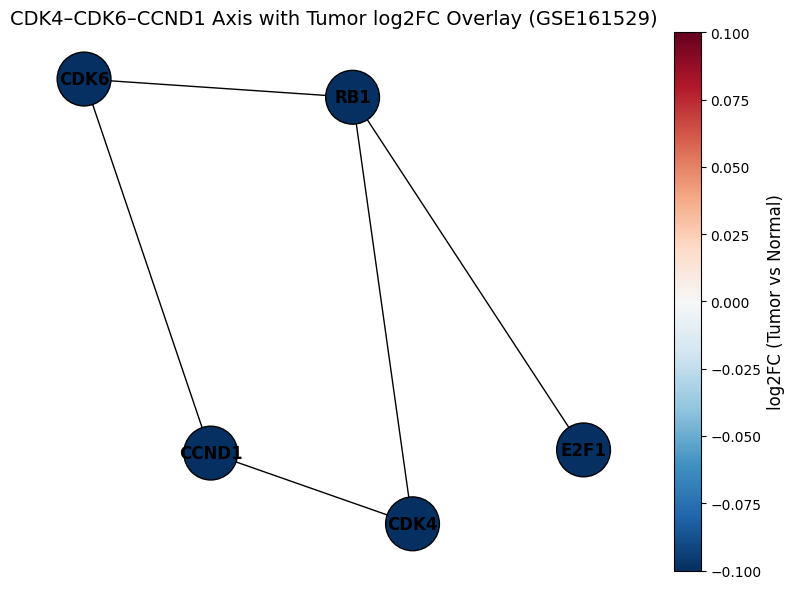

In [87]:
# ✅ Step 2: Subset your updated gene_stat_df
subset_df = gene_stat_df[gene_stat_df["Gene"].isin(genes_of_interest)]

# ✅ Step 3: Create log2FC dictionary
if subset_df.empty:
    raise ValueError("None of the genes in the G1/S axis were found in gene_stat_df.")
log2fc_dict = dict(zip(subset_df["Gene"], subset_df["log2FC"]))

# ✅ Step 4: Define directed edges for the axis
edges = [
    ("CCND1", "CDK4"),
    ("CCND1", "CDK6"),
    ("CDK4", "RB1"),
    ("CDK6", "RB1"),
    ("RB1", "E2F1")
]

# ✅ Step 5: Create the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# ✅ Step 6: Normalize node colors by log2FC
values = [log2fc_dict.get(node, 0) for node in G.nodes]
vmin, vmax = min(values), max(values)

# Use balanced normalization
if vmin < 0 < vmax:
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cmap = cm.get_cmap("RdBu_r")
node_colors = [cmap(norm(log2fc_dict.get(node, 0))) for node in G.nodes]

# ✅ Step 7: Draw the network
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(8, 6))

nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', edge_color="black")
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, edgecolors="black")

# ✅ Step 8: Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm,  ax=plt.gca())
cbar.set_label("log2FC (Tumor vs Normal)", fontsize=12)

plt.title("CDK4–CDK6–CCND1 Axis with Tumor log2FC Overlay (GSE161529)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

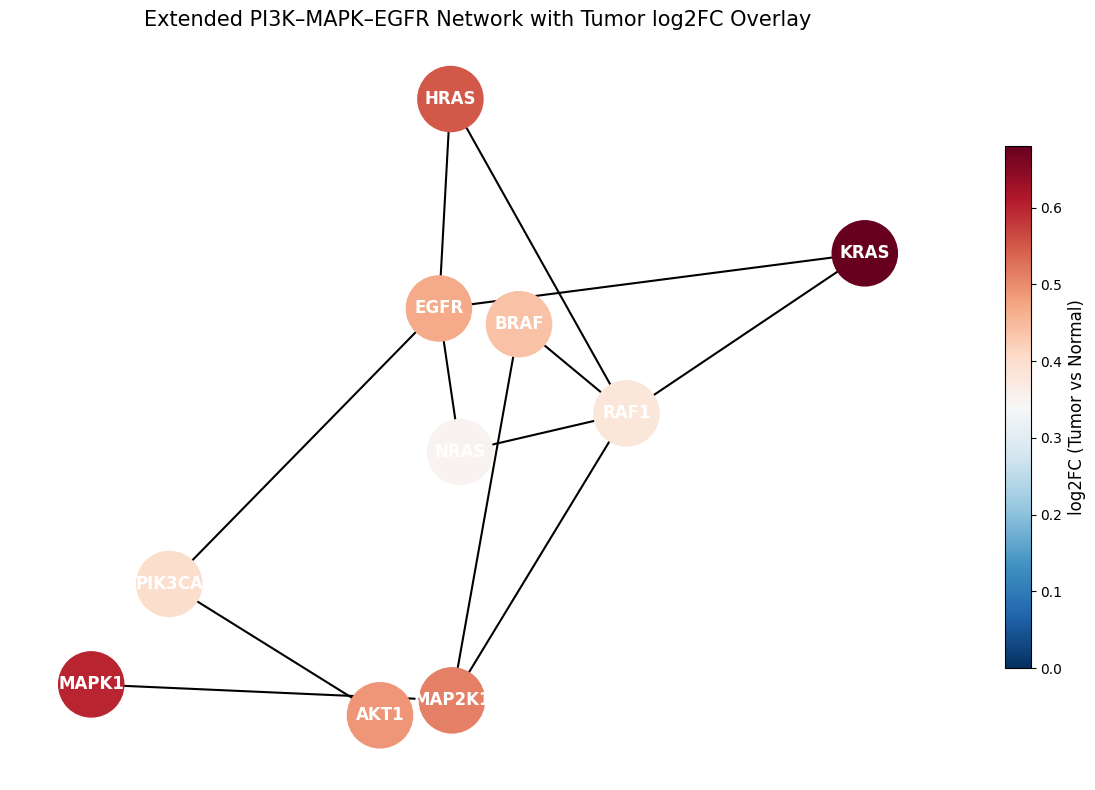

In [76]:
# Build the directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Map log2FC values to node colors
nodes = G.nodes()
log2fc_values = [log2fc_dict.get(node, 0) for node in nodes]
norm = mcolors.Normalize(vmin=0, vmax=max(log2fc_values))
cmap = cm.RdBu_r  # Blue (low) to Red (high)
node_colors = [cmap(norm(val)) for val in log2fc_values]

# Draw the graph
fig, ax = plt.subplots(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42, k=0.7)

nx.draw_networkx_edges(G, pos, arrows=True, edge_color='black', width=1.5, ax=ax)
nx.draw_networkx_nodes(G, pos, node_size=2200, node_color=node_colors, ax=ax)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white', font_weight='bold', ax=ax)

# Colorbar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label("log2FC (Tumor vs Normal)", fontsize=12)

plt.title("Extended PI3K–MAPK–EGFR Network with Tumor log2FC Overlay", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\Haider-Rizvi\AppData\Local\Temp\ipykernel_8252\1720250502.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdBu_r")


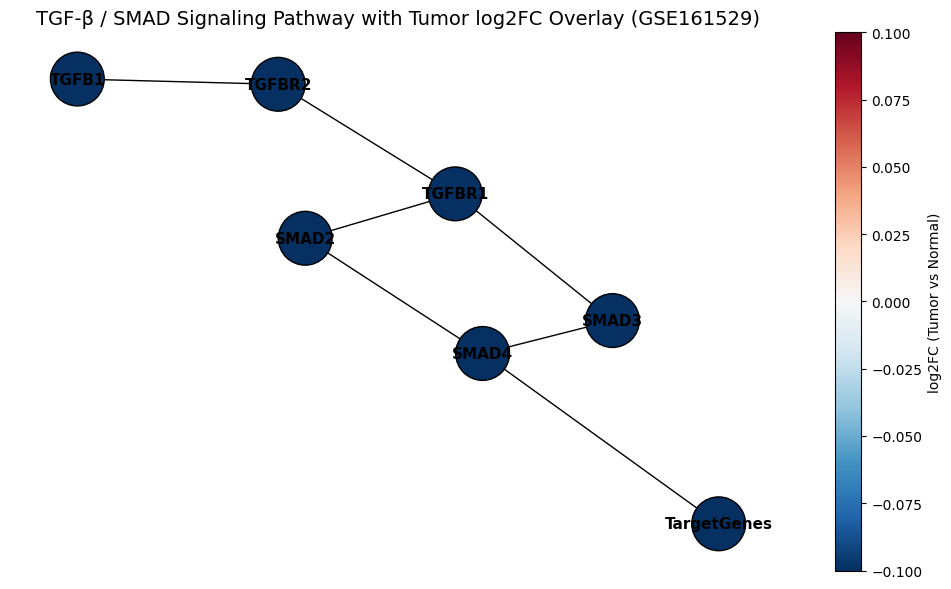

In [78]:
# STEP 1: Define pathway structure (simplified canonical TGF-β signaling)
edges = [
    ("TGFB1", "TGFBR2"),
    ("TGFBR2", "TGFBR1"),
    ("TGFBR1", "SMAD2"),
    ("TGFBR1", "SMAD3"),
    ("SMAD2", "SMAD4"),
    ("SMAD3", "SMAD4"),
    ("SMAD4", "TargetGenes")  # placeholder for downstream effects
]

# STEP 2: Extract genes from edges
tgfb_genes = list(set(g for edge in edges for g in edge if g != "TargetGenes"))

# STEP 3: Create log2FC dictionary from your DE dataframe
# Assumes gene_stat_df has "Gene" and "log2FC" columns
subset_df = gene_stat_df[gene_stat_df["Gene"].isin(tgfb_genes)]
log2fc_dict = dict(zip(subset_df["Gene"], subset_df["log2FC"]))

# STEP 4: Create the graph
G = nx.DiGraph()
G.add_edges_from(edges)

# STEP 5: Map log2FC to node colors
values = [log2fc_dict.get(node, 0) for node in G.nodes]
#vmin, vmax = min(values), max(values)
vmin, vmax = min(values), max(values)

if vmin < 0 < vmax:
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)


#norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = cm.get_cmap("RdBu_r")
node_colors = [cmap(norm(log2fc_dict.get(node, 0))) for node in G.nodes]

# STEP 6: Draw network
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_edges(G, pos, arrows=True, edge_color="black")
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, edgecolors="black")

# Add colorbar - Fix: specify the current axes
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label="log2FC (Tumor vs Normal)")

plt.title("TGF-β / SMAD Signaling Pathway with Tumor log2FC Overlay (GSE161529)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

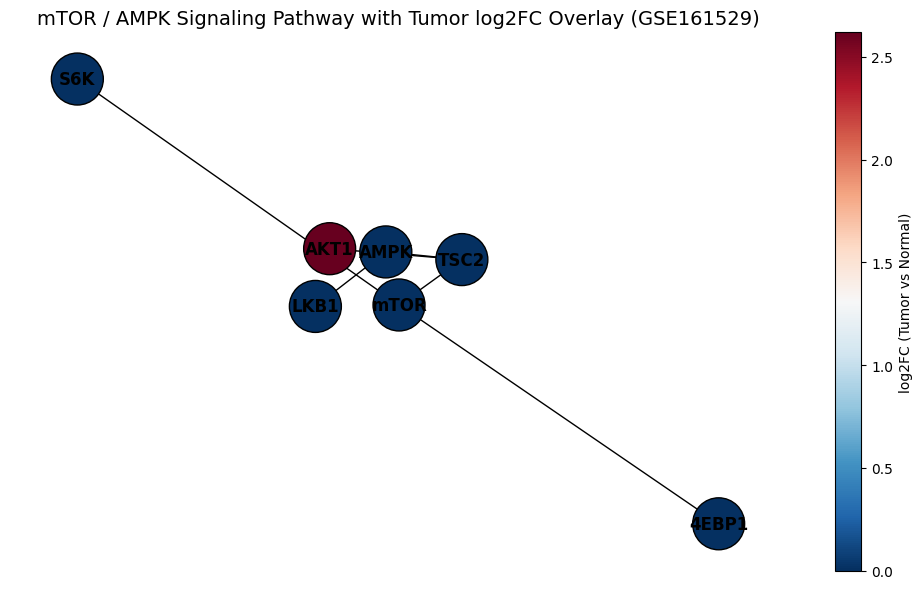

In [80]:
# ✅ Step 1: Define the mTOR–AMPK pathway structure
edges = [
    ("LKB1", "AMPK"),
    ("AMPK", "TSC2"),
    ("TSC2", "mTOR"),
    ("AKT1", "TSC2"),
    ("mTOR", "S6K"),
    ("mTOR", "4EBP1")
]

# ✅ Step 2: Genes in the network
genes = list(set([gene for edge in edges for gene in edge]))

# ✅ Step 3: Extract log2FC values from your differential expression DataFrame
# Ensure 'Gene' and 'log2FC' columns are in gene_stat_df
subset = gene_stat_df[gene_stat_df["Gene"].isin(genes)]
if subset.empty:
    raise ValueError("None of the genes in the mTOR–AMPK network were found in gene_stat_df.")

log2fc_dict = dict(zip(subset["Gene"], subset["log2FC"]))

# ✅ Step 4: Create the graph and color by log2FC
G = nx.DiGraph()
G.add_edges_from(edges)

values = [log2fc_dict.get(node, 0) for node in G.nodes]
vmin, vmax = min(values), max(values)

# Choose appropriate colormap
if vmin < 0 < vmax:
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
else:
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

cmap = cm.RdBu_r
node_colors = [cmap(norm(log2fc_dict.get(node, 0))) for node in G.nodes]

# ✅ Step 5: Plot the graph
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 6))

nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', edge_color="black")
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1400, edgecolors='black')

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label="log2FC (Tumor vs Normal)")

plt.title("mTOR / AMPK Signaling Pathway with Tumor log2FC Overlay (GSE161529)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [81]:
# Combining multiple signaling axes (e.g., PI3K–MAPK–EGFR, CDK4–CDK6–CCND1, and MYC) into a 
# composite matplotlib figure panel
# Log2FC data
log2fc_dict = {
    "EGFR": 0.5, "KRAS": 0.3, "RAF1": 0.4, "MAP2K1": 0.6, "MAPK1": 0.2, "PIK3CA": 0.4, "AKT1": 0.7,
    "CDK4": 0.91, "CDK6": 0.89, "CCND1": 1.12, "RB1": -0.2, "E2F1": 0.3,
    "MYC": 0.8, "BCL2": 0.5, "MDM2": 2.8, "TP53": -0.6
}

# Define pathway edges
pathways = {
    "PI3K–MAPK–EGFR Axis": [
        ("EGFR", "KRAS"), ("KRAS", "RAF1"), ("RAF1", "MAP2K1"),
        ("MAP2K1", "MAPK1"), ("EGFR", "PIK3CA"), ("PIK3CA", "AKT1")
    ],
    "CDK4–CDK6–CCND1 Axis": [
        ("CCND1", "CDK4"), ("CCND1", "CDK6"), ("CDK4", "RB1"), ("CDK6", "RB1"), ("RB1", "E2F1")
    ],
    "MYC Signaling Axis": [
        ("MYC", "CDK4"), ("MYC", "CDK6"), ("MYC", "CCND1"), ("MYC", "BCL2"),
        ("MYC", "MDM2"), ("MDM2", "TP53")
    ]
}

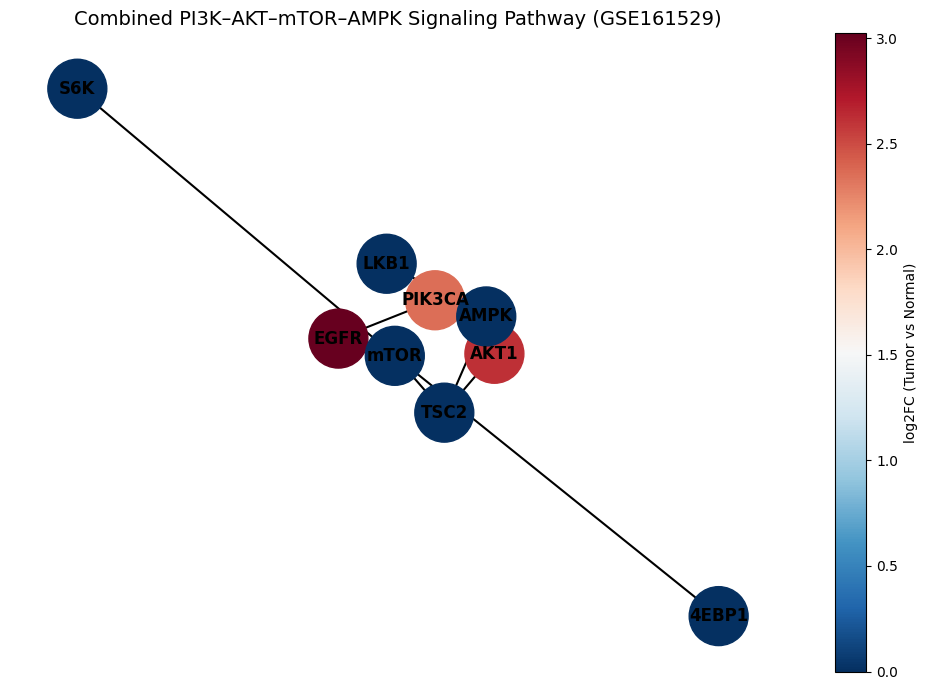

In [83]:
# Step 1: Define nodes (pathway genes)
genes = ["EGFR", "PIK3CA", "AKT1", "TSC2", "mTOR", "S6K", "4EBP1", "LKB1", "AMPK"]

# Step 2: Define edges (signal flow)
edges = [
    ("EGFR", "PIK3CA"),
    ("PIK3CA", "AKT1"),
    ("AKT1", "TSC2"),
    ("TSC2", "mTOR"),
    ("mTOR", "S6K"),
    ("mTOR", "4EBP1"),
    ("LKB1", "AMPK"),
    ("AMPK", "TSC2")  # AMPK inhibits TSC2
]

# Step 3: Extract log2FC from your gene_stat_df
log2fc_dict = dict(zip(gene_stat_df["Gene"], gene_stat_df["log2FC"]))
values = [log2fc_dict.get(gene, 0) for gene in genes]

# Step 4: Normalize log2FC values for color mapping
vmin, vmax = 0, max(values)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.RdBu_r
node_colors = [cmap(norm(log2fc_dict.get(g, 0))) for g in genes]

# Step 5: Build and plot the network
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', edge_color="black", width=1.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1800)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

# Step 6: Add colorbar legend
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label="log2FC (Tumor vs Normal)")

plt.title("Combined PI3K–AKT–mTOR–AMPK Signaling Pathway (GSE161529)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Expression values
log2fc_dict = {
    "EGFR": 0.5, "KRAS": 0.3, "RAF1": 0.4, "MAP2K1": 0.6, "MAPK1": 0.2, "PIK3CA": 0.4, "AKT1": 0.7,
    "CDK4": 0.91, "CDK6": 0.89, "CCND1": 1.12, "RB1": -0.2, "E2F1": 0.3,
    "MYC": 0.8, "BCL2": 0.5, "MDM2": 2.8, "TP53": -0.6
}

# Druggable targets and known drugs
druggable_targets = {
    "EGFR": "Erlotinib", "PIK3CA": "Alpelisib", "AKT1": "Capivasertib",
    "CDK4": "Palbociclib", "CDK6": "Ribociclib", "CCND1": "Abemaciclib",
    "MDM2": "Milademetan", "BCL2": "Venetoclax", "MYC": "Omomyc"
}

# Pathways
pathways = {
    "PI3K–MAPK–EGFR Axis": [
        ("EGFR", "KRAS"), ("KRAS", "RAF1"), ("RAF1", "MAP2K1"),
        ("MAP2K1", "MAPK1"), ("EGFR", "PIK3CA"), ("PIK3CA", "AKT1")
    ],
    "CDK4–CDK6–CCND1 Axis": [
        ("CCND1", "CDK4"), ("CCND1", "CDK6"), ("CDK4", "RB1"), ("CDK6", "RB1"), ("RB1", "E2F1")
    ],
    "MYC Signaling Axis": [
        ("MYC", "CDK4"), ("MYC", "CDK6"), ("MYC", "CCND1"), ("MYC", "BCL2")

    ]
}

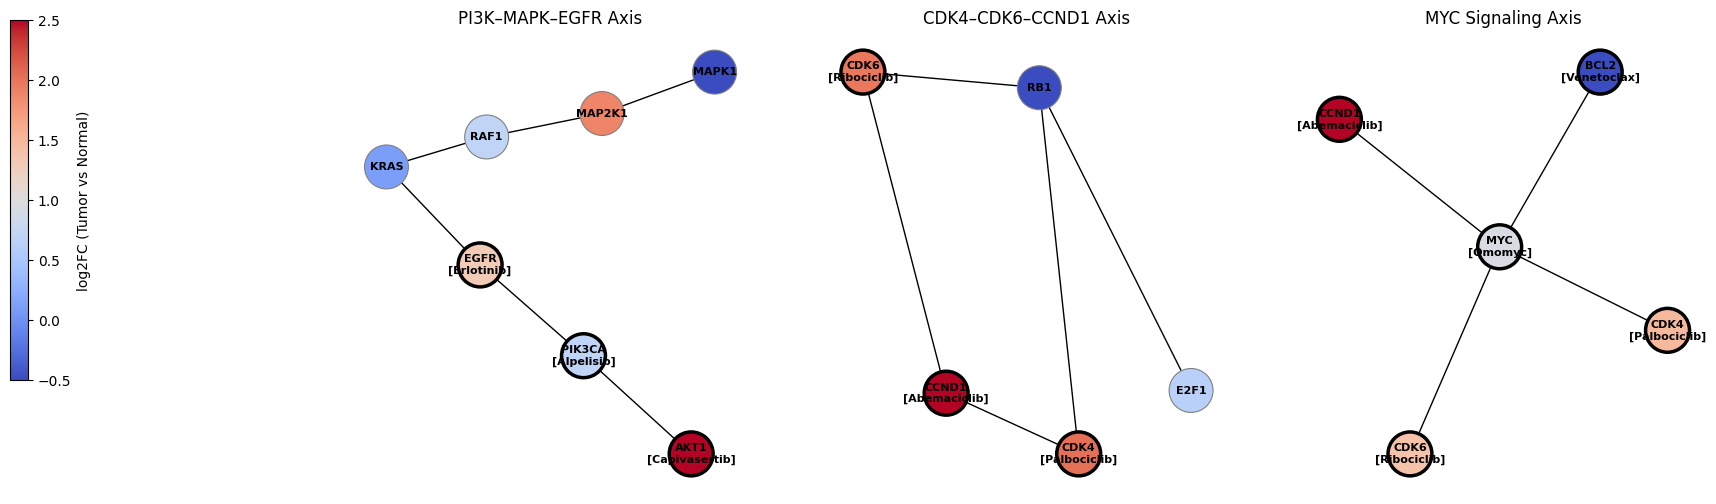

In [ ]:
# Set up figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=False)
cmap = plt.cm.coolwarm
norm = mpl.colors.Normalize(vmin=-0.5, vmax=2.5)

# Plot networks
for ax, (title, edges) in zip(axes, pathways.items()):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed=42)
    values = np.array([log2fc_dict.get(node, 0) for node in G.nodes()])

    node_border_colors = ['black' if node in druggable_targets else 'gray' for node in G.nodes()]
    node_border_widths = [2.5 if node in druggable_targets else 0.8 for node in G.nodes()]

    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_nodes(
        G, pos, node_color=values, cmap=cmap, node_size=1000,
        ax=ax, edgecolors=node_border_colors, linewidths=node_border_widths
    )

    for node, (x, y) in pos.items():
        drug = f"\n[{druggable_targets[node]}]" if node in druggable_targets else ""
        ax.text(x, y, f"{node}{drug}", ha='center', va='center',
                color='black', fontsize=8, fontweight='bold')

    ax.set_title(title)
    ax.axis('off')

# Add vertical colorbar to the left
fig.subplots_adjust(left=0.15)
cbar_ax = fig.add_axes([-0.04, 0.3, 0.01, 0.6])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="vertical")
cbar.set_label("log2FC (Tumor vs Normal)")

plt.show()